<a href="https://colab.research.google.com/github/pragneshanekal/model-interpretability/blob/main/Model_Interpretability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
%pip install h2o

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.6/265.6 MB 2.3 MB/s eta 0:00:00


In [76]:
%pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 5.9 MB/s eta 0:00:00


In [77]:
import pandas as pd
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.graphics.regressionplots import plot_partregress_grid
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
import h2o
from h2o.automl import H2OAutoML
import shap

In [ ]:
nba_df = pd.read_csv("/content/drive/My Drive/cleaned_all_seasons.csv")

In [ ]:
print(nba_df.isnull().any())

player_name          False
team_abbreviation    False
age                  False
player_height        False
player_weight        False
college              False
country              False
draft_year           False
draft_round          False
draft_number         False
gp                   False
pts                  False
reb                  False
ast                  False
net_rating           False
oreb_pct             False
dreb_pct             False
usg_pct              False
ts_pct               False
ast_pct              False
season               False
age_category         False
dtype: bool


### Linear Model and Coeffecient Interpretation

In [22]:
# Convert all draft_number values to strings for uniform processing
nba_df['draft_number'] = nba_df['draft_number'].astype(str)

# Identify the maximum numerical draft number, excluding 'Undrafted'
max_draft_number = nba_df[nba_df['draft_number'] != 'Undrafted']['draft_number'].astype(int).max()

# Define a function to encode draft_number, treating 'Undrafted' as the lowest rank
def encode_draft_number(value):
    if value == 'Undrafted':
        return max_draft_number + 1 # Assign 'Undrafted' the highest numerical value to indicate the lowest rank
    else:
        return int(value) # Convert numerical draft positions to integers

# Apply the encoding function to the 'draft_number' column
nba_df['encoded_draft_number'] = nba_df['draft_number'].apply(encode_draft_number)

In [87]:
numeric_columns = ['age', 'player_height', 'player_weight', 'gp', 'reb', 'ast', 'net_rating',
                   'oreb_pct', 'dreb_pct', 'usg_pct', 'ts_pct', 'ast_pct', 'encoded_draft_number']

x = nba_df[numeric_columns]
y = nba_df['pts']

In [88]:
# Proceed with your OLS model using 'interaction_terms_df' instead of 'X_poly'
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
X_train_sm = sm.add_constant(X_train)  # Add a constant to the model
linear_model = sm.OLS(y_train, X_train_sm).fit()
p_values = linear_model.pvalues

linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    pts   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     5274.
Date:                Sun, 17 Mar 2024   Prob (F-statistic):               0.00
Time:                        18:30:30   Log-Likelihood:                -22528.
No. Observations:               10275   AIC:                         4.508e+04
Df Residuals:                   10261   BIC:                         4.518e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -5.3672      0.822     -6.530      0.000      -6.978      -3.756
age                   -8.32e-05      0.005     -0.016      0.987      -0.010       0.010
player_height            0.0065      0.005      1.388      0.165      -0.003       0.016
player_weight           -0.0046      0.003     -1.420      0.156      -0.011       0.002
gp                       0.0148      0.001     13.293      0.000       0.013       0.017
reb                      1.2128      0.015     78.457      0.000       1.183       1.243
ast                      1.5994      0.025     63.007      0.000       1.550       1.649
net_rating               0.0118      0.002      6.523      0.000       0.008       0.015
oreb_pct               -21.5876      0.672    -32.125      0.000     -22.905     -20.270
dreb_pct               -16.1966      0.526    -30.808      0.000     -17.227     -15.166
usg_pct                 42.9871      0.454     94.706      0.000      42.097      43.877
ts_pct                   5.2568      0.238     22.072      0.000       4.790       5.724
ast_pct                -17.6519      0.456    -38.691      0.000     -18.546     -16.758
encoded_draft_number    -0.0023      0.000     -5.569      0.000      -0.003      -0.001
==============================================================================
Omnibus:                     2636.119   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           159515.247
Skew:                          -0.316   Prob(JB):                         0.00
Kurtosis:                      22.292   Cond. No.                     9.41e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.41e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

1. Intercept: The intercept, -5.3672, represents the expected value of 'pts' when all other predictors are 0. Given the context, this may not have a practical interpretation as many of these predictors cannot be zero in real scenarios.

2. Age: The coefficient of -8.32e-05 suggests a very slight decrease in 'pts' with each year of age, but given the p-value of 0.987, this effect is not statistically significant, implying age may not be a good predictor of points scored.

3. Player Height: The coefficient of 0.0065 indicates that for each additional unit of height (likely in inches or centimeters), the points scored increase slightly. However, the p-value of 0.165 suggests this relationship is not statistically significant.

4. Player Weight: Similarly, -0.0046 for weight suggests a slight decrease in points scored with increasing weight, but this is also not statistically significant (p-value of 0.156).

5. Games Played: With a coefficient of 0.0148, there's a significant positive relationship between the number of games played and points scored (p-value < 0.0001). This implies that playing more games is associated with scoring more points.

6. Rebounds: A coefficient of 1.2128, with a highly significant p-value, indicates a strong positive association between rebounds and points scored. Each additional rebound is associated with an increase in points scored.

7. Assists: Assists have a coefficient of 1.5994, showing a significant positive impact on points scored. This relationship is also statistically significant.

8. Net Rating: A coefficient of 0.0118 suggests a positive relationship with points scored, significant at the 0.000 level, indicating that better net ratings correlate with higher points scored.

9. Offensive Rebound %: The negative coefficient of -21.5876 indicates a significant decrease in points with higher offensive rebound percentages, which might seem counterintuitive but could reflect roles within the team.

10. Defensive Rebound %, Usage %, True Shooting %, Assist %: These variables show significant positive or negative relationships with points scored, indicated by their coefficients and very low p-values. For example, a higher usg_pct is strongly associated with more points scored (42.9871). In contrast, a higher ast_pct is associated with fewer points scored (-17.6519), potentially indicating a more facilitative rather than scoring role on the team.

11. Draft Number: Each unit increase in the encoded draft number is associated with a slight decrease in points scored, with a coefficient of -0.0023, suggesting that players drafted earlier may score slightly more points on average.

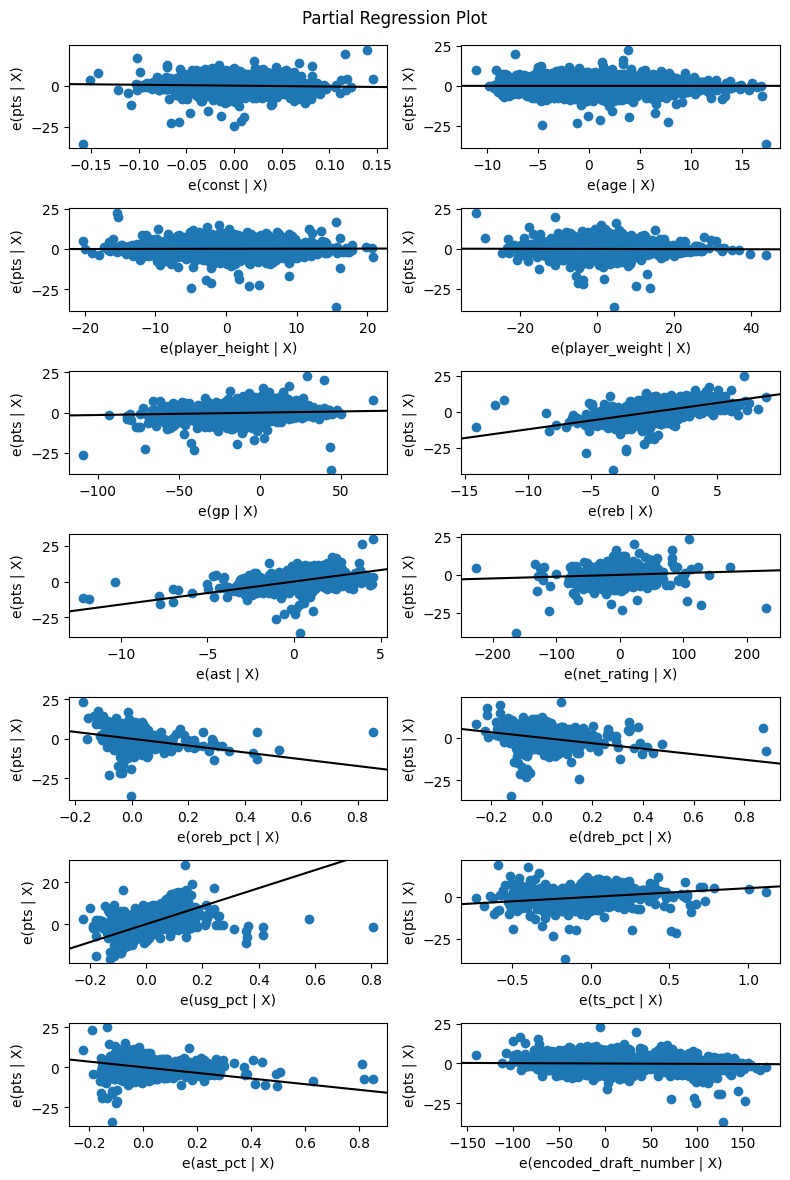

In [32]:
# Create partial regression plots for all predictors
fig = plt.figure(figsize=(8, 12))
plot_partregress_grid(model, fig=fig)
plt.show()

The partial regression plot displays the relationship between the response variable and a selected predictor, adjusted for the effects of other variables in the model. In the example of 'ast', the upward-sloping line suggests a positive relationship with 'pts', indicating that an increase in assists is associated with an increase in points scored. These plots are useful for discerning the individual contribution of each predictor to the response variable

### Tree-Based Model and Nodes Interpretation

In [122]:
rf_X_train, rf_X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Create and train the Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(rf_X_train, y_train)

RandomForestRegressor(random_state=42)

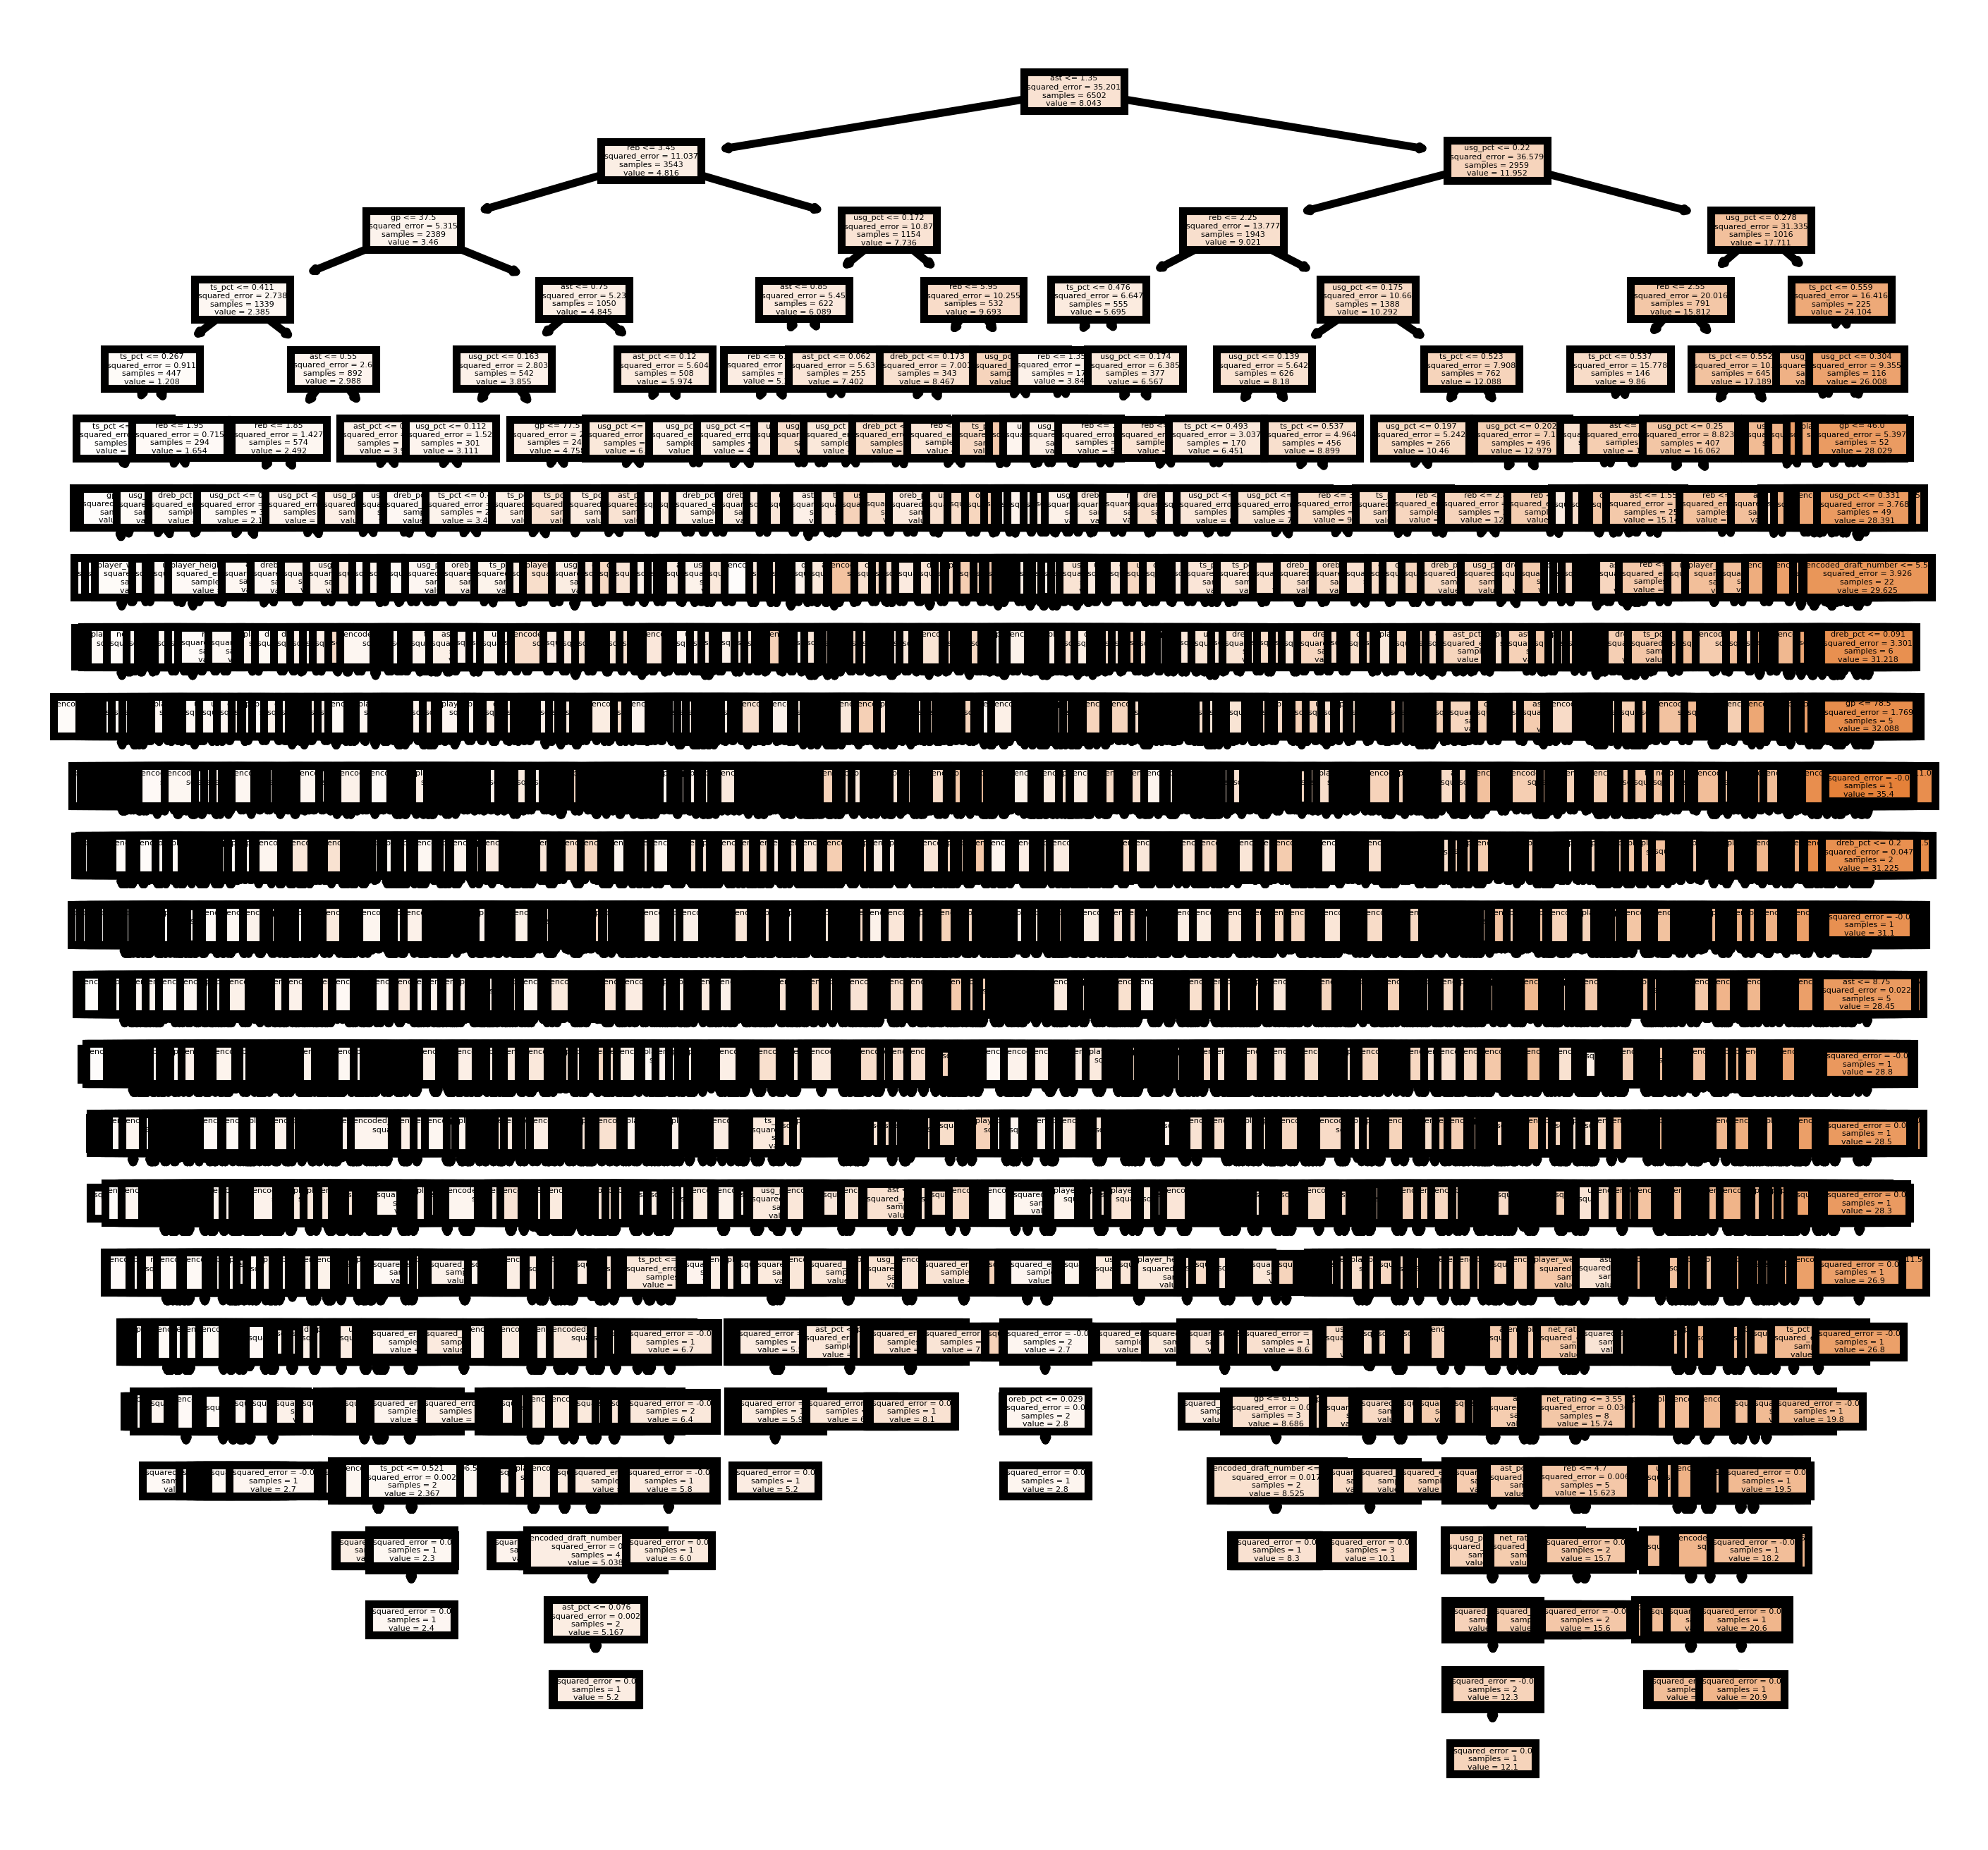

In [39]:
single_tree = rf.estimators_[0]

# Visualize the tree using 'tree' module from 'sklearn'
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (4, 4), dpi=800)
tree.plot_tree(single_tree,
               feature_names = numeric_columns,
               filled = True)

# To display the plot
plt.show()

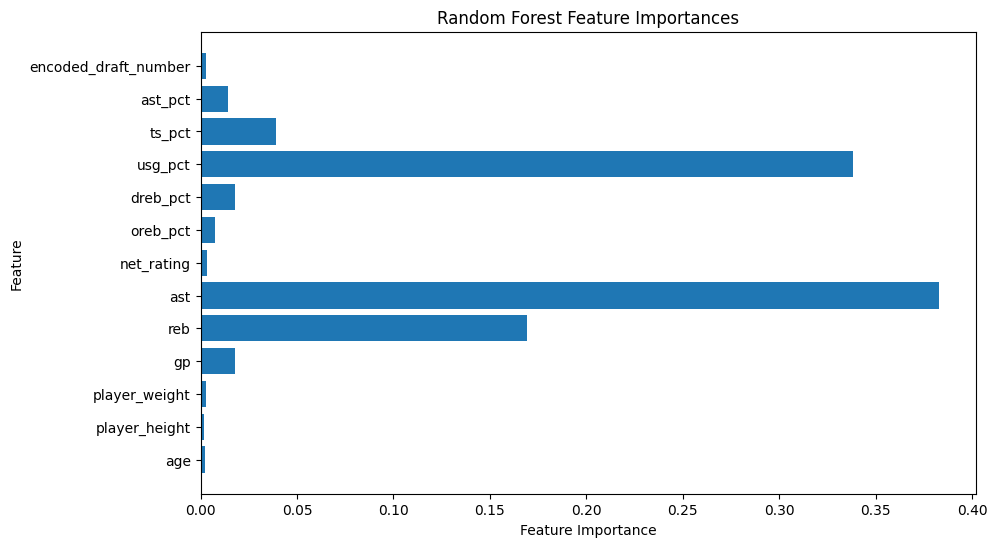

In [45]:
# Get feature importances
importances = rf.feature_importances_

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(importances)), importances, align='center')
plt.yticks(range(len(numeric_columns)), numeric_columns)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importances')
plt.show()

In [49]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.22" 2024-01-16; OpenJDK Runtime Environment (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1); OpenJDK 64-Bit Server VM (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpzp2ccomu
  JVM stdout: /tmp/tmpzp2ccomu/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpzp2ccomu/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,04 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,4 days
H2O_cluster_name:,H2O_from_python_unknownUser_mubmjl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [50]:
# Then adjust the path to where the file is located in your Google Drive
nba_data = h2o.import_file("/content/drive/My Drive/cleaned_all_seasons.csv")

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [51]:
# Convert categorical columns to factors
categorical_columns = ['draft_year',
                       'draft_round', 'draft_number']
for col in categorical_columns:
    nba_data[col] = nba_data[col].asfactor()

# Verify the conversion
nba_data.types

{'player_name': 'enum',
 'team_abbreviation': 'enum',
 'age': 'int',
 'player_height': 'real',
 'player_weight': 'real',
 'college': 'enum',
 'country': 'enum',
 'draft_year': 'enum',
 'draft_round': 'enum',
 'draft_number': 'enum',
 'gp': 'int',
 'pts': 'real',
 'reb': 'real',
 'ast': 'real',
 'net_rating': 'real',
 'oreb_pct': 'real',
 'dreb_pct': 'real',
 'usg_pct': 'real',
 'ts_pct': 'real',
 'ast_pct': 'real',
 'season': 'enum',
 'age_category': 'enum'}

In [52]:
response = "pts"
predictors = list(nba_data.columns)
predictors.remove('pts')

In [61]:
# Split into train & test
splits = nba_data.split_frame(ratios=[0.8], seed=1)
train = splits[0]
test = splits[1]

# Run AutoML for 1 minute
aml = H2OAutoML(max_runtime_secs=60, seed=1)
aml.train(y=response, training_frame=train)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),5/8
# GBM base models (used / total),1/4
# XGBoost base models (used / total),2/2
# GLM base models (used / total),1/1
# DRF base models (used / total),1/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None


In [62]:
# Get the best model from the leaderboard
best_model = aml.leader

# Get the model ID of the best model
best_model_id = best_model.model_id

# Get the model type of the best model
best_model_type = best_model.algo

print("Best Model ID:", best_model_id)
print("Best Model Type:", best_model_type)

Best Model ID: StackedEnsemble_AllModels_1_AutoML_3_20240317_175300
Best Model Type: stackedensemble


# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

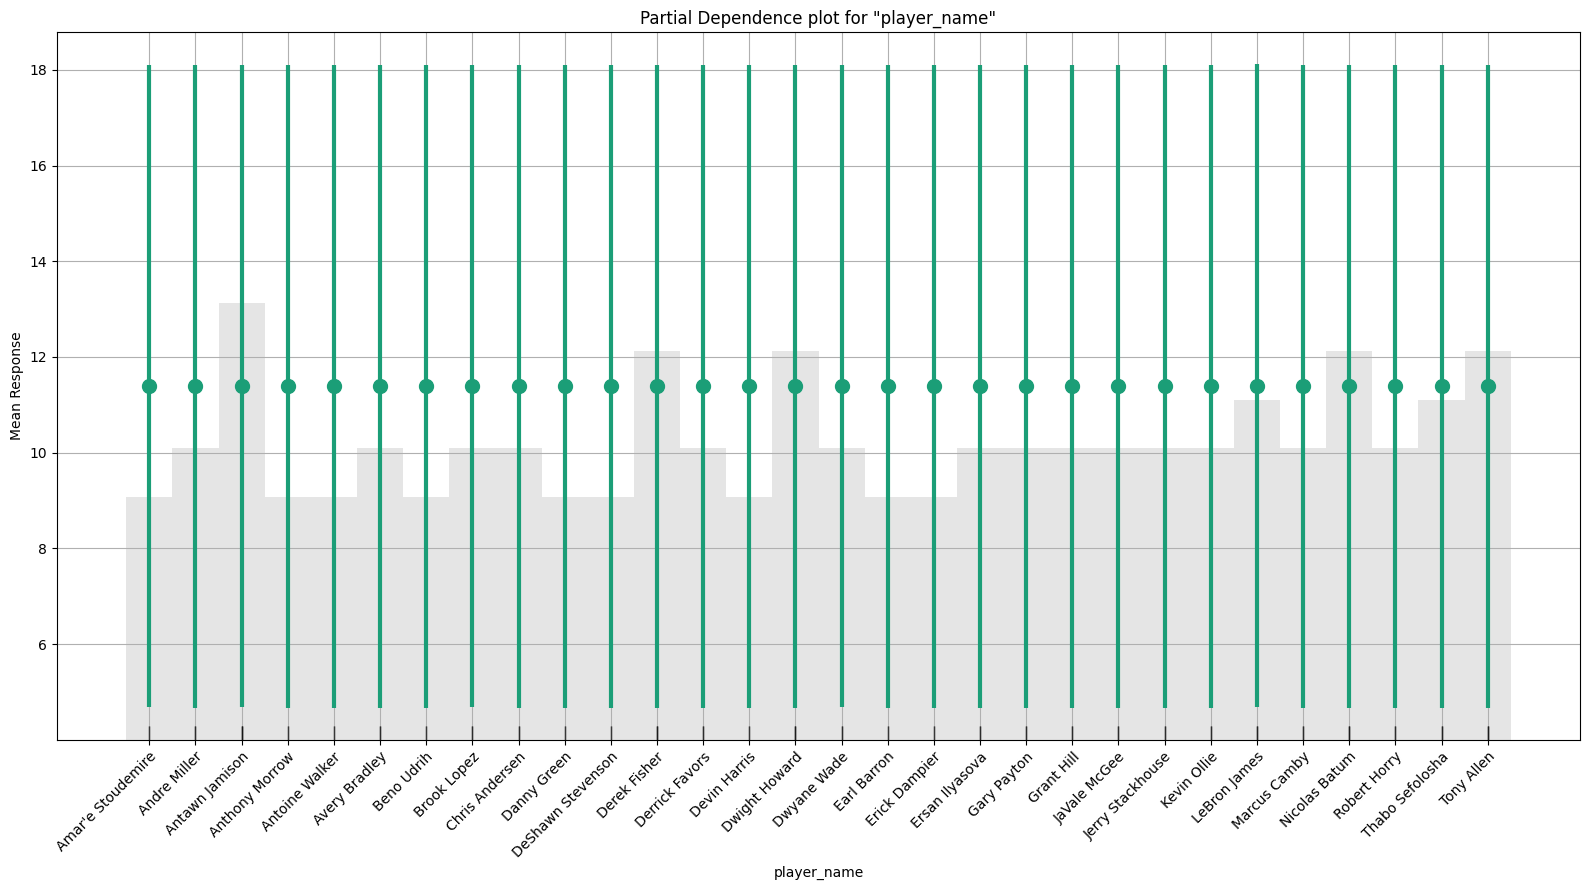

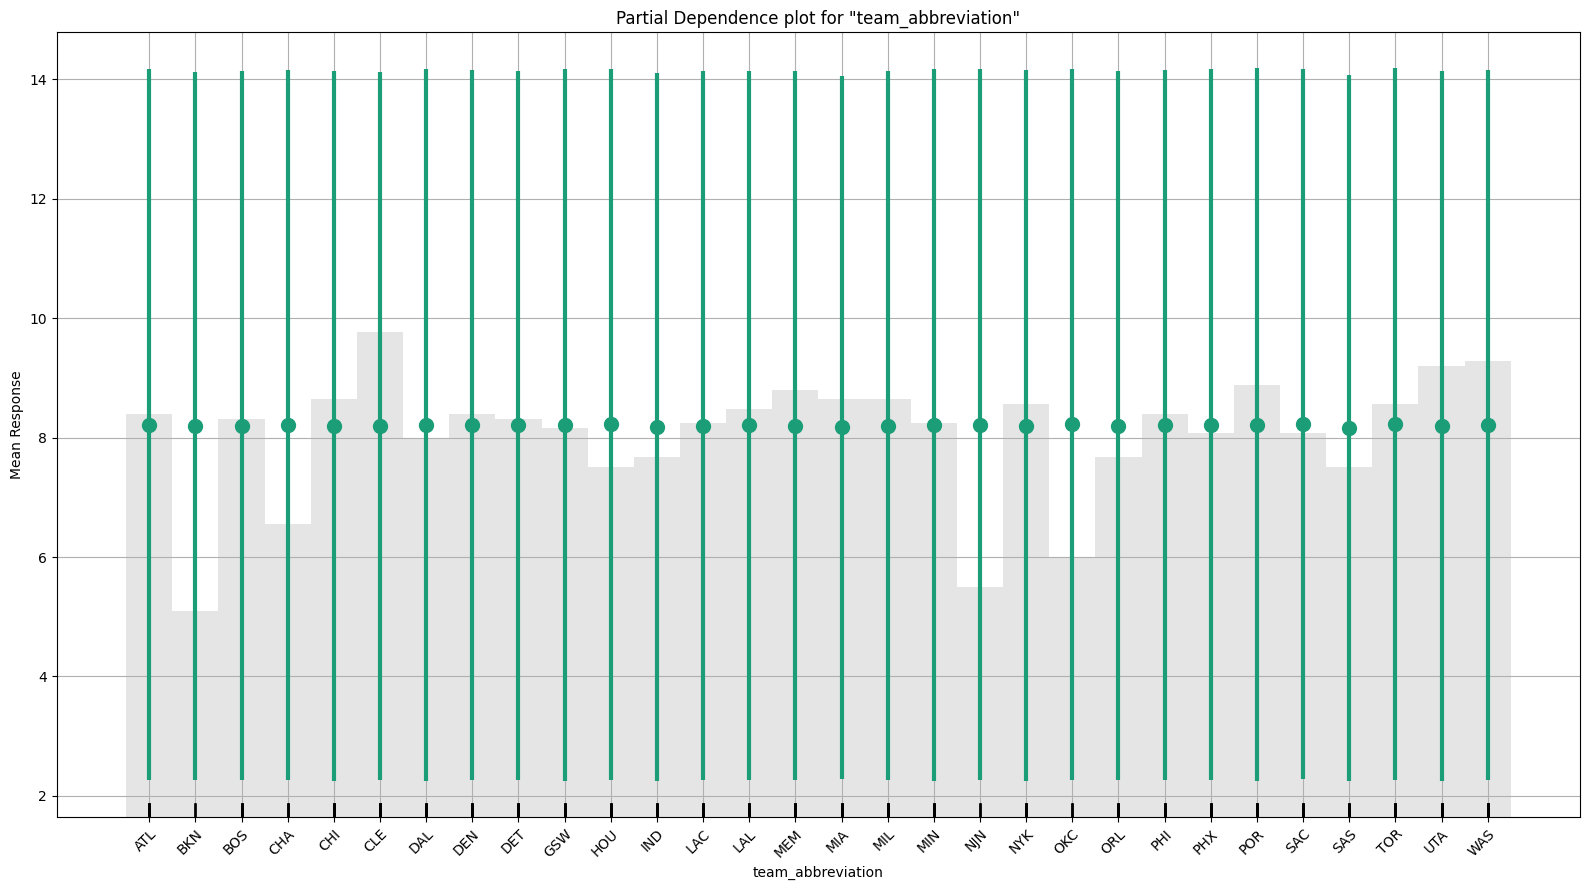

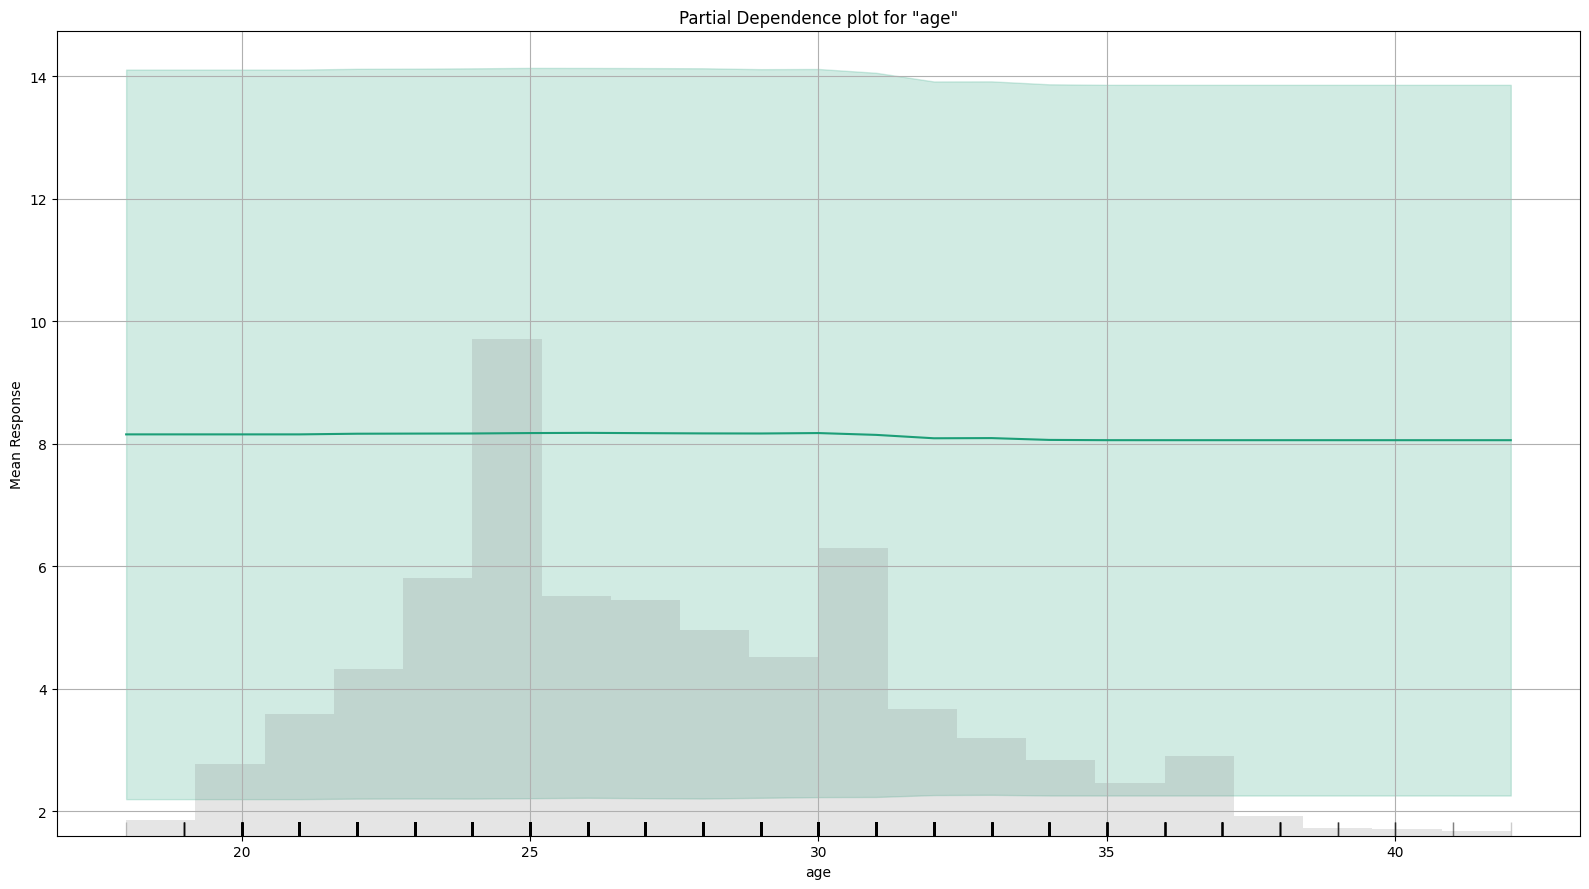

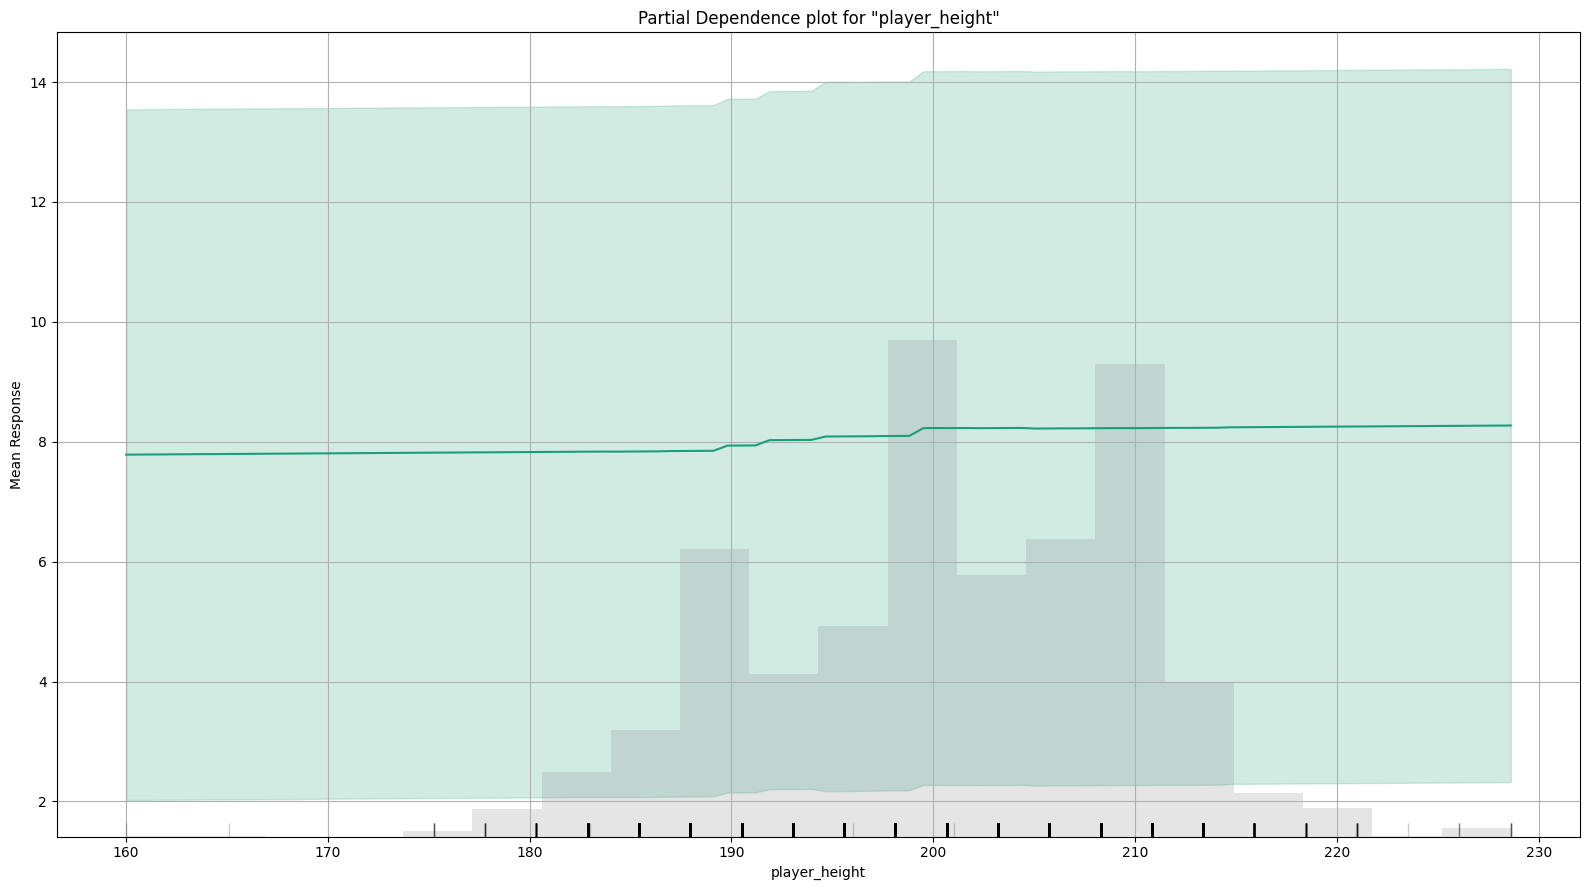

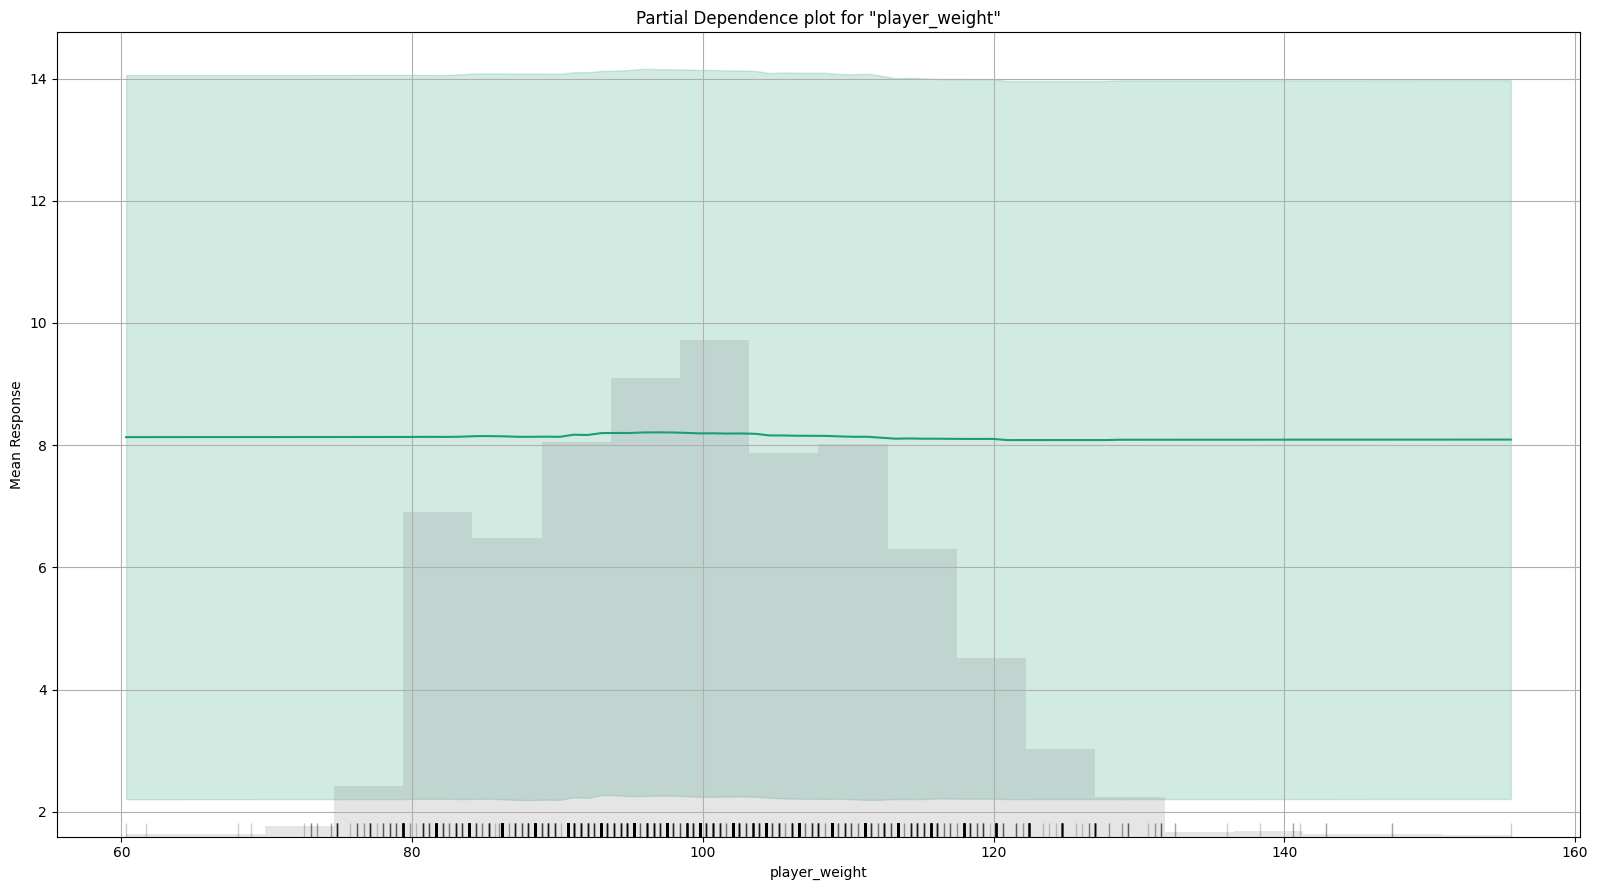

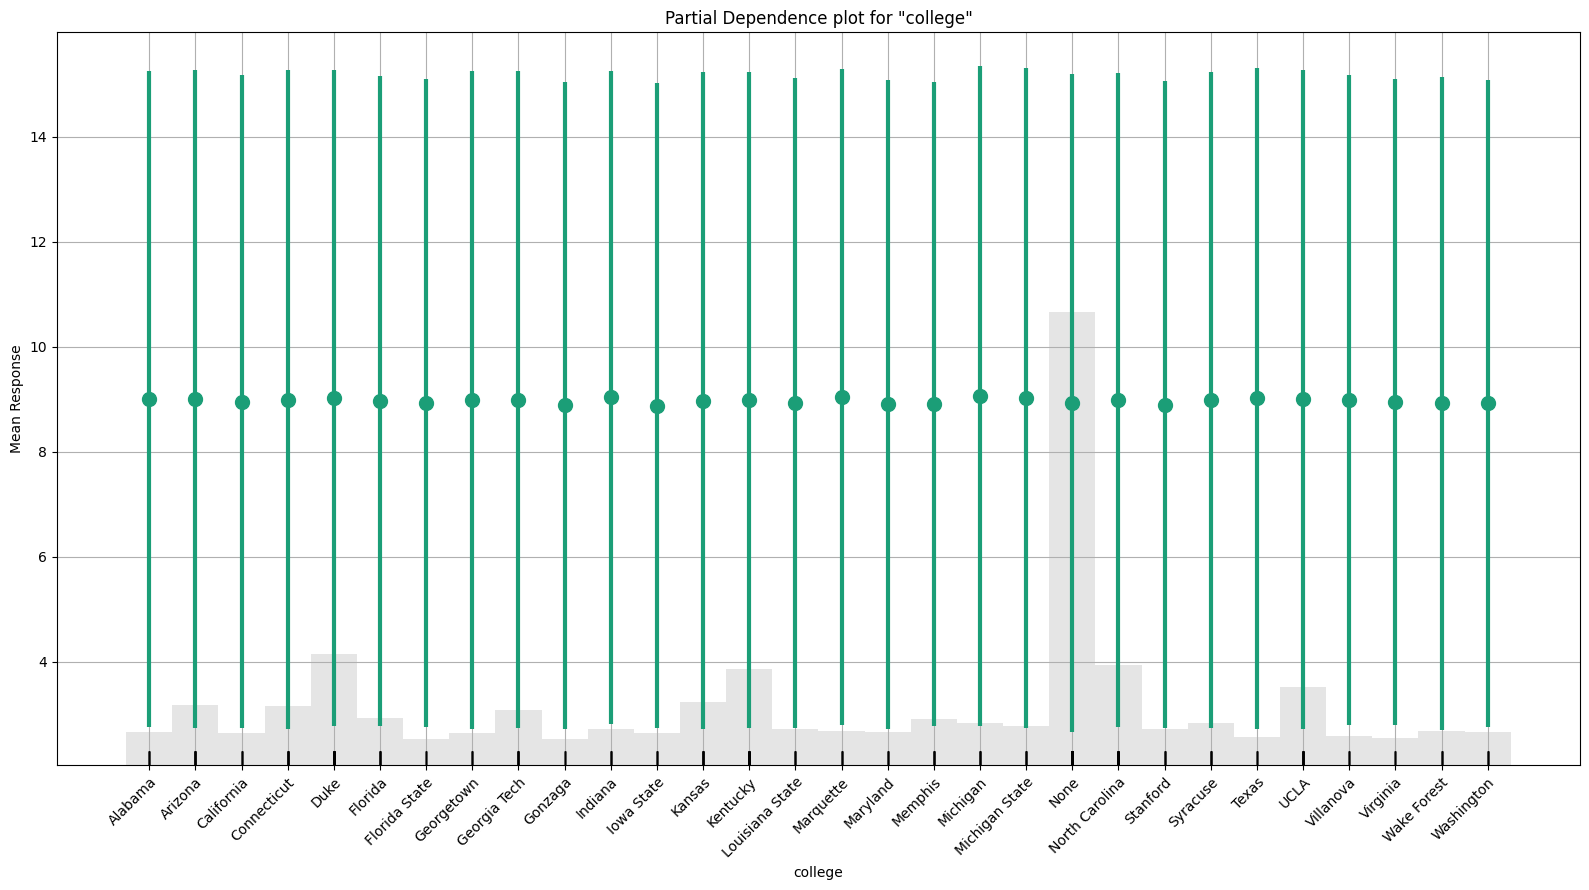

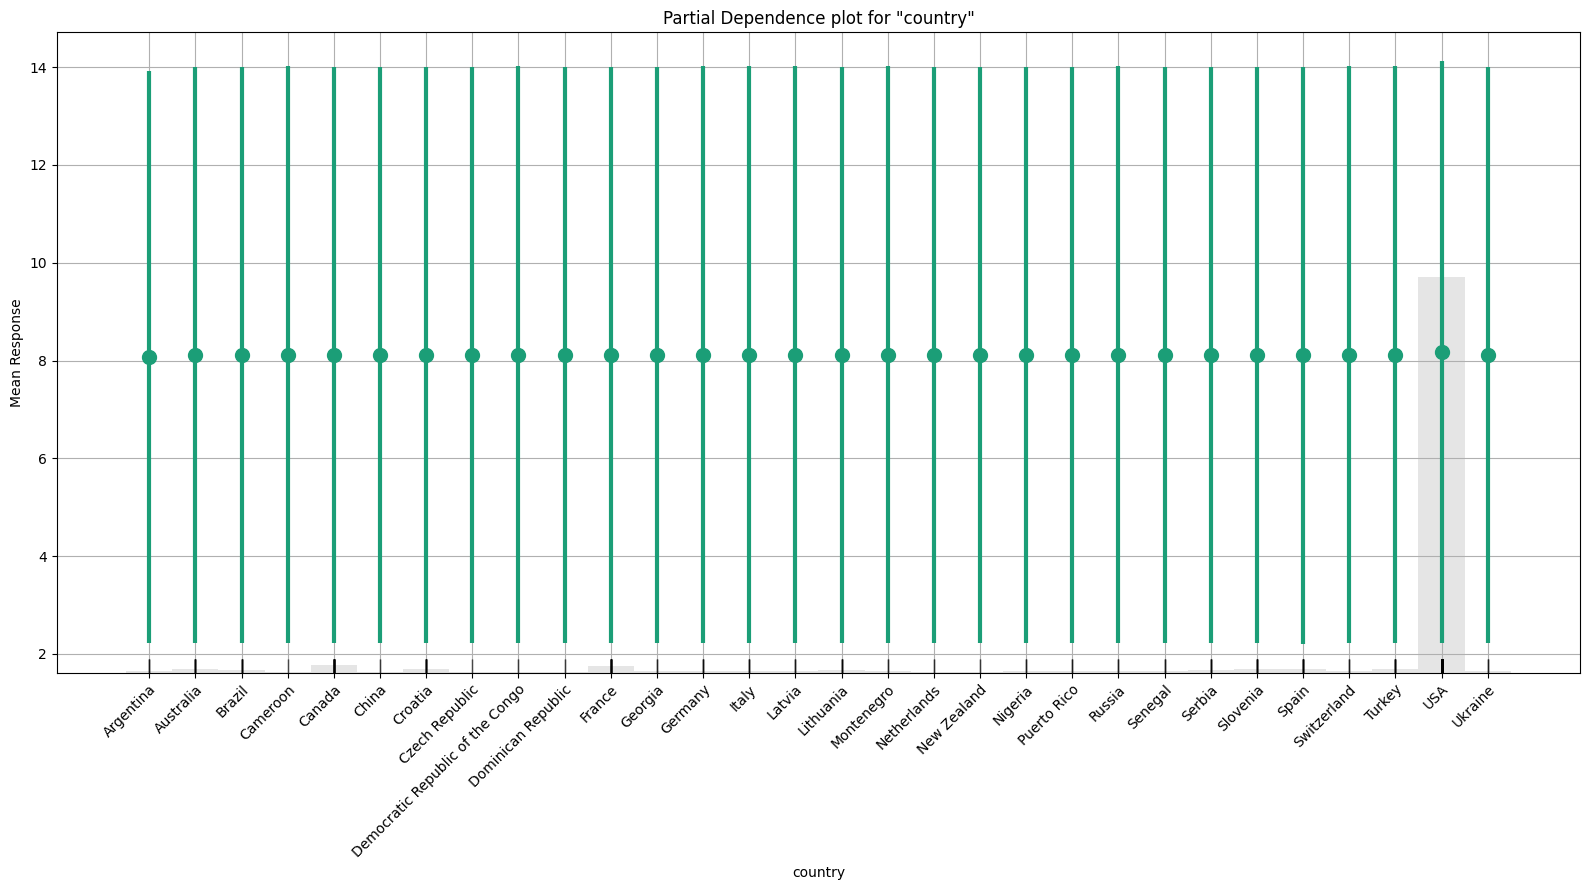

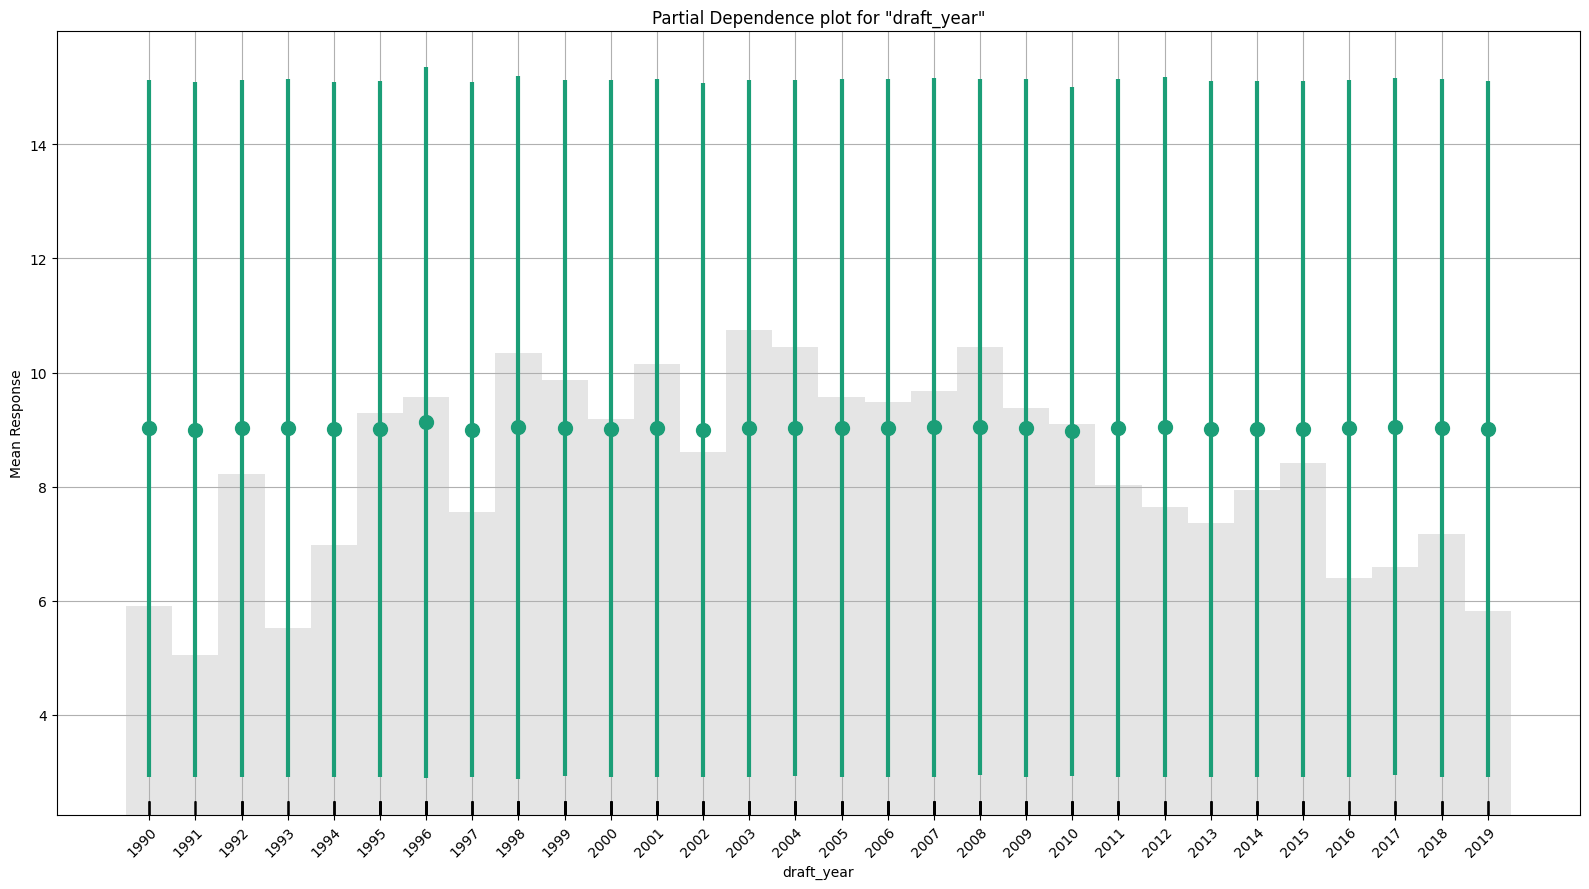

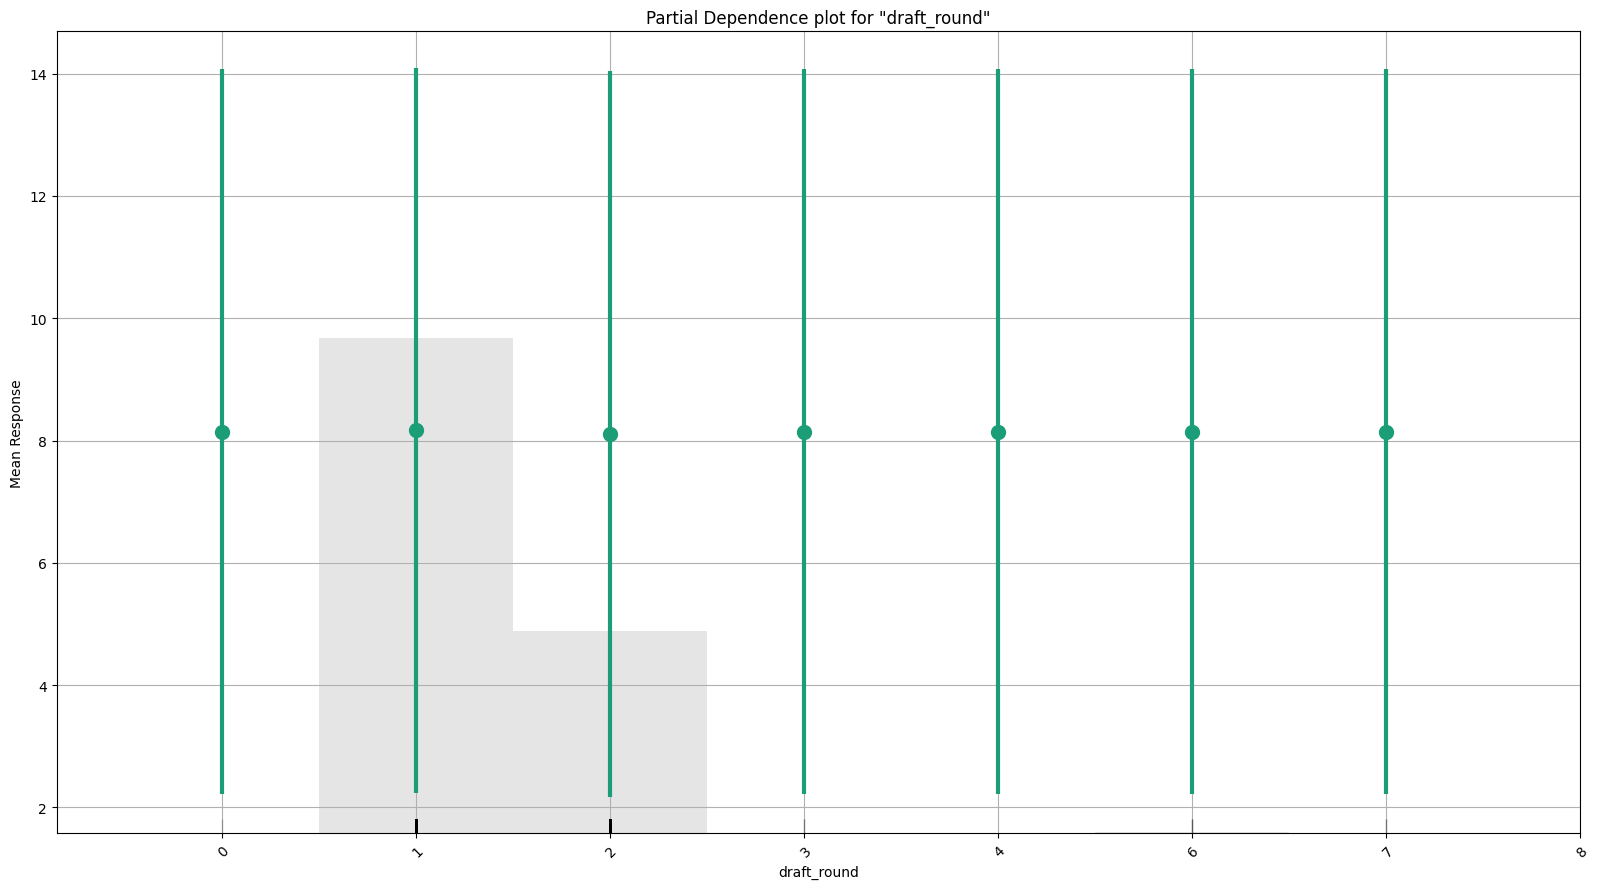

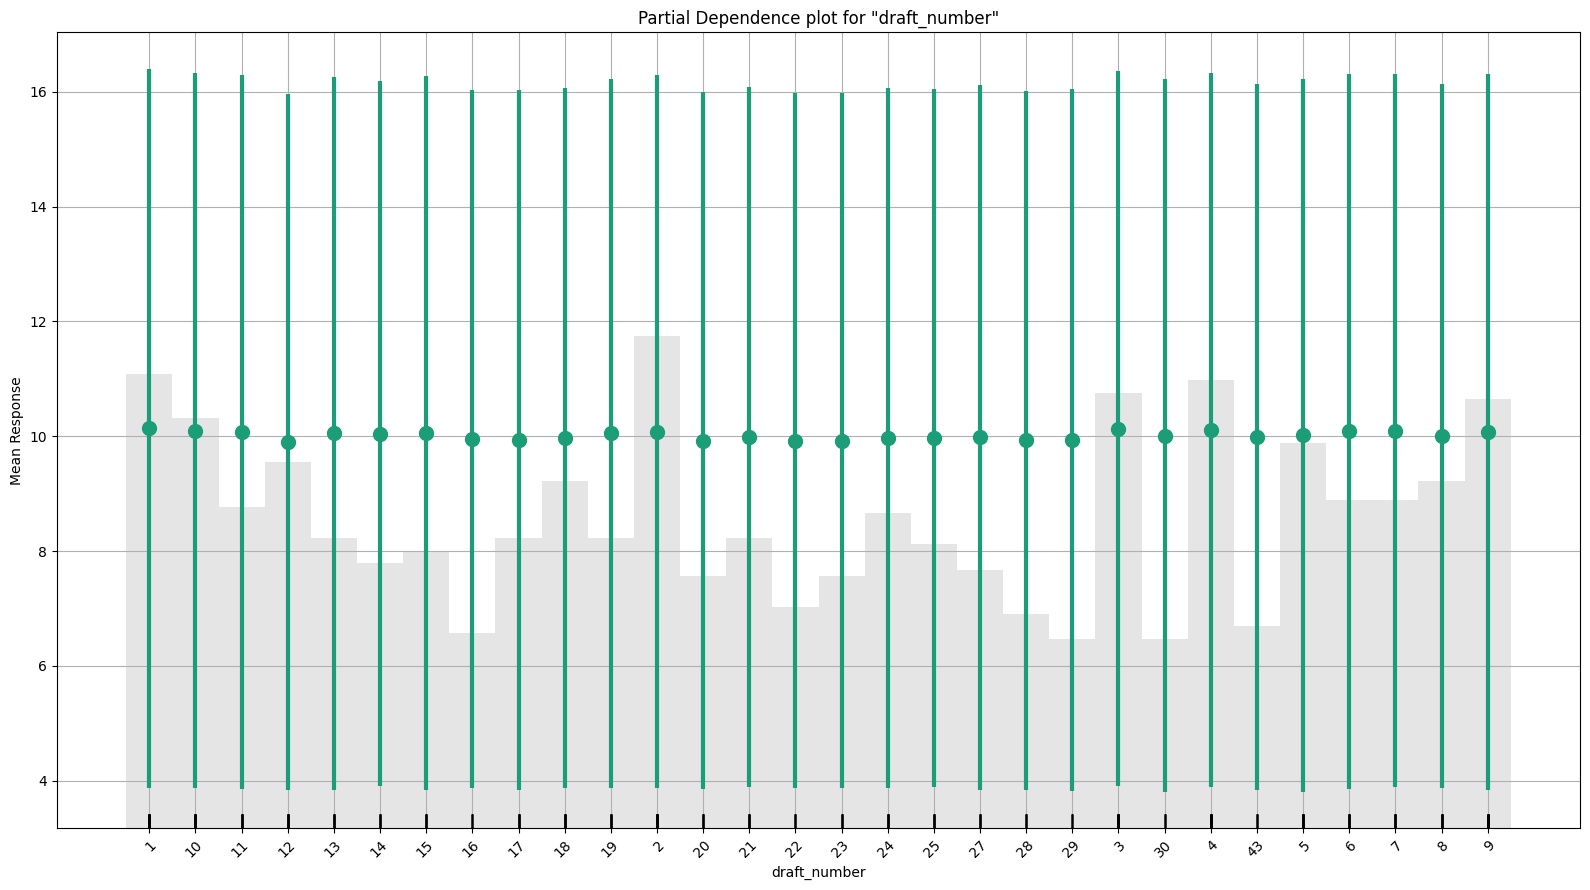

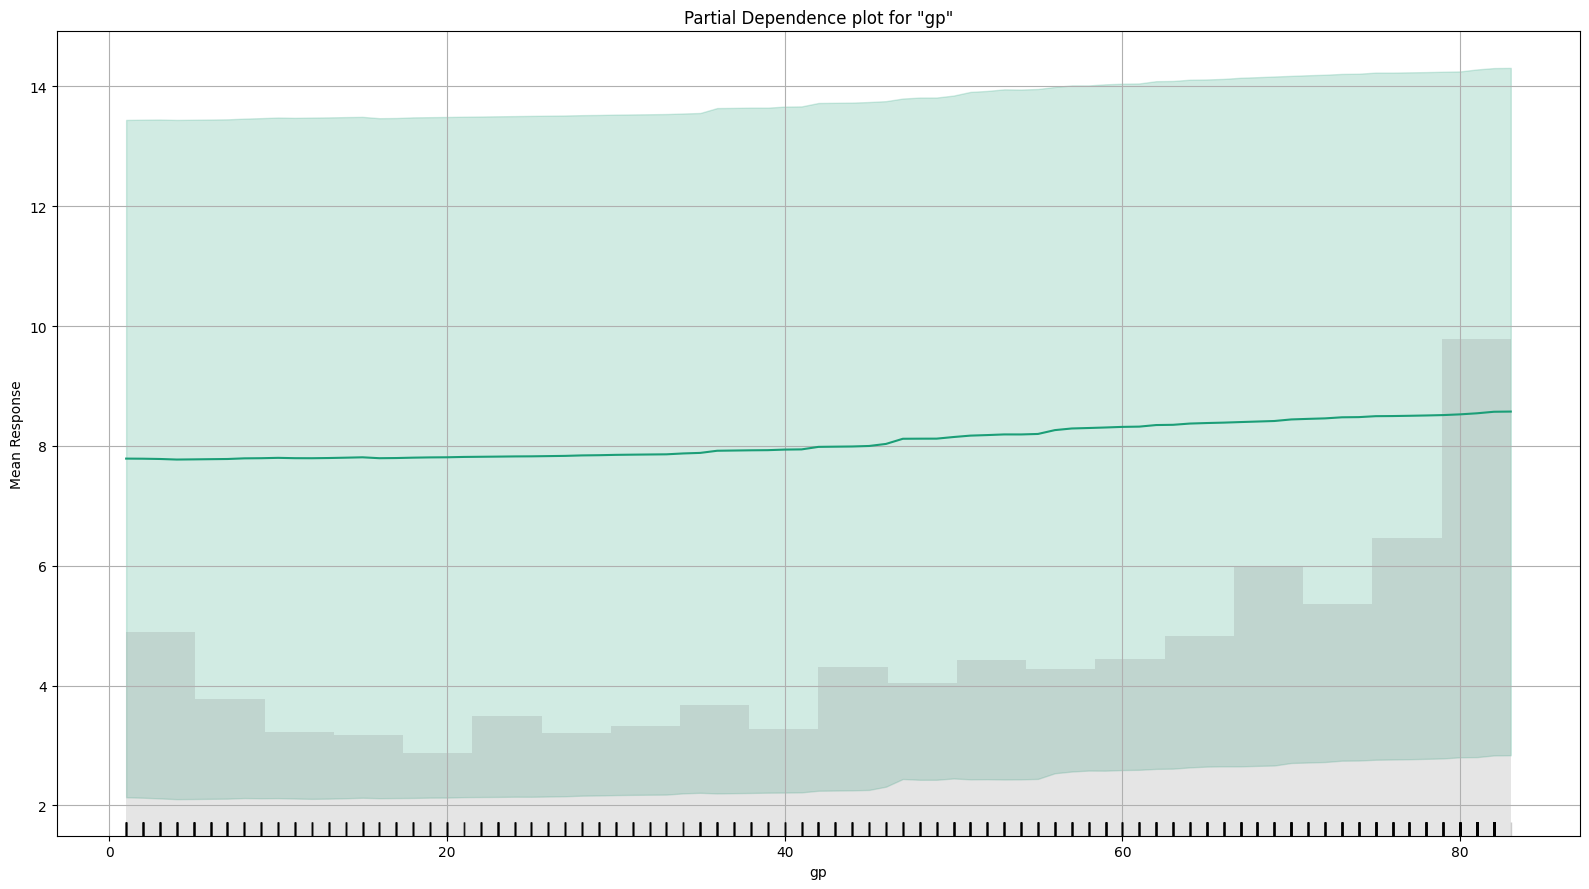

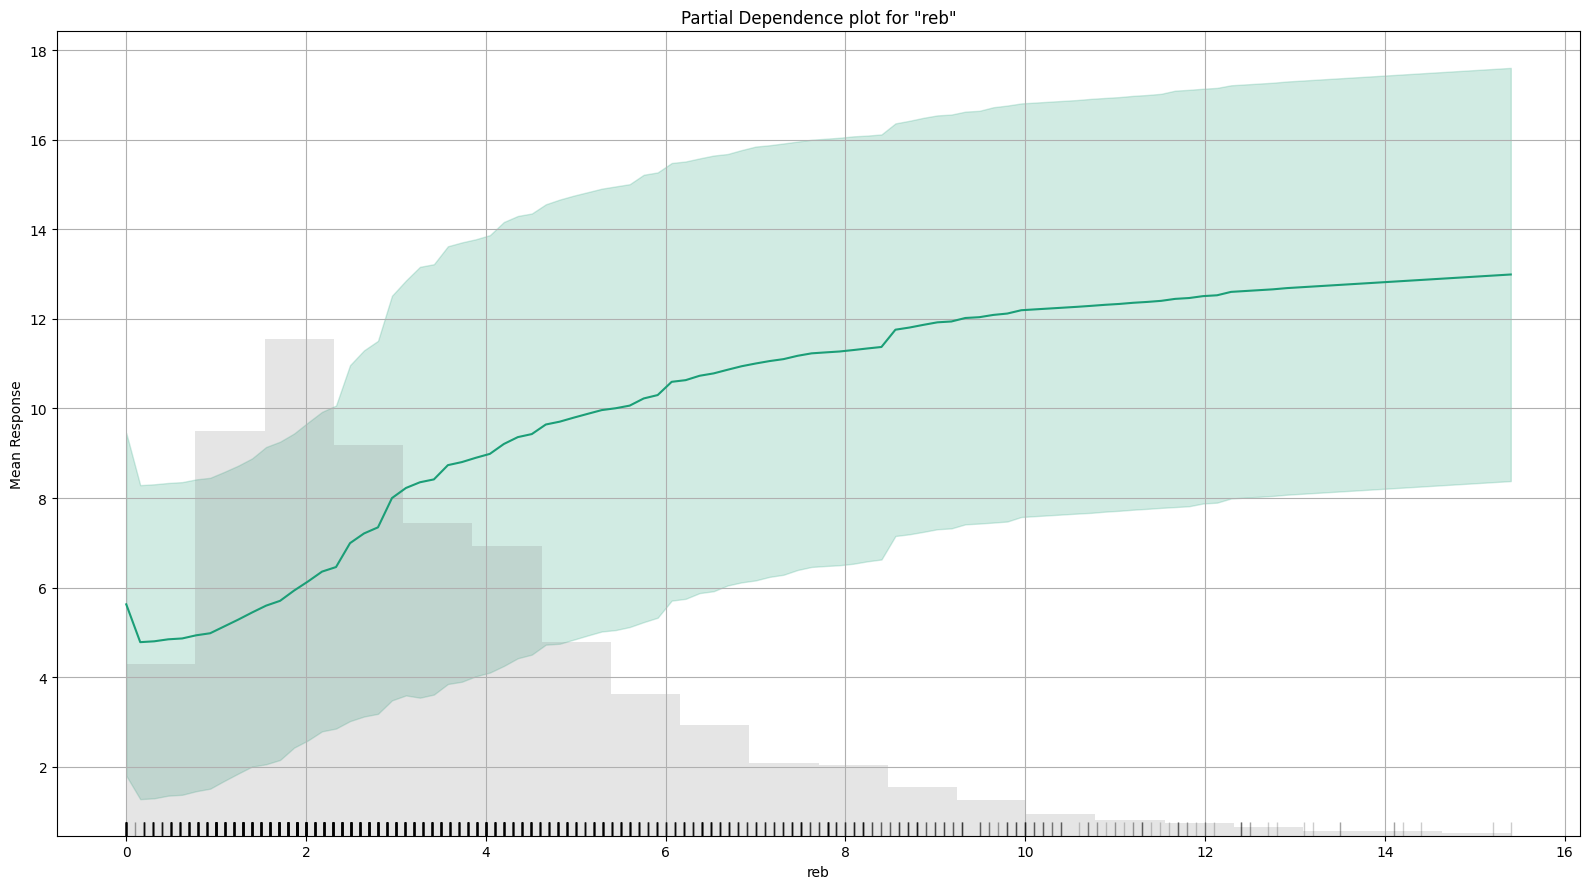

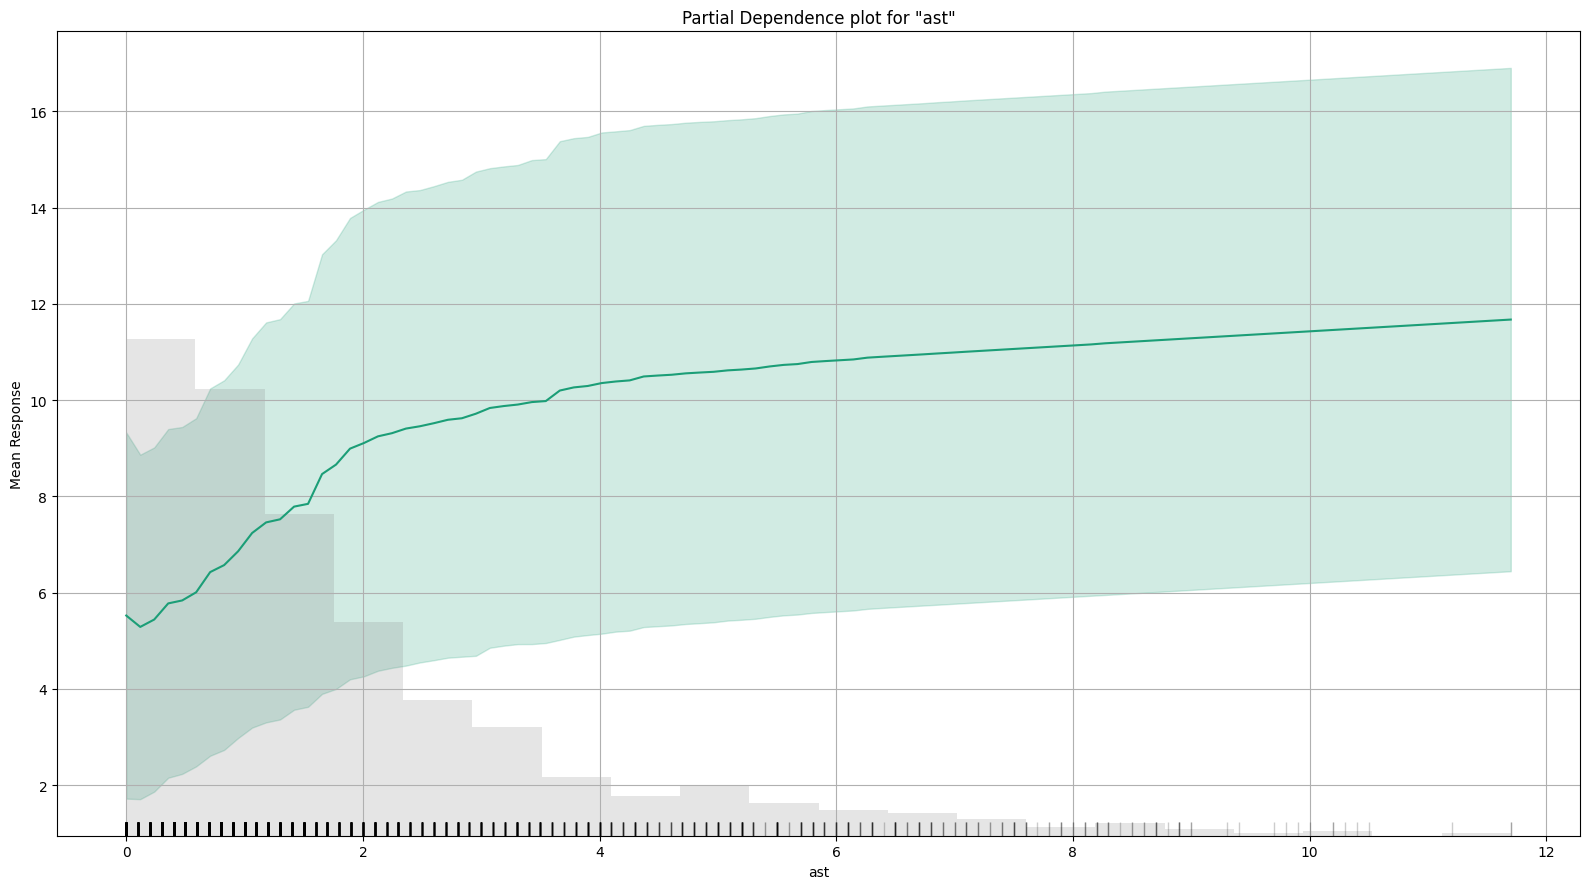

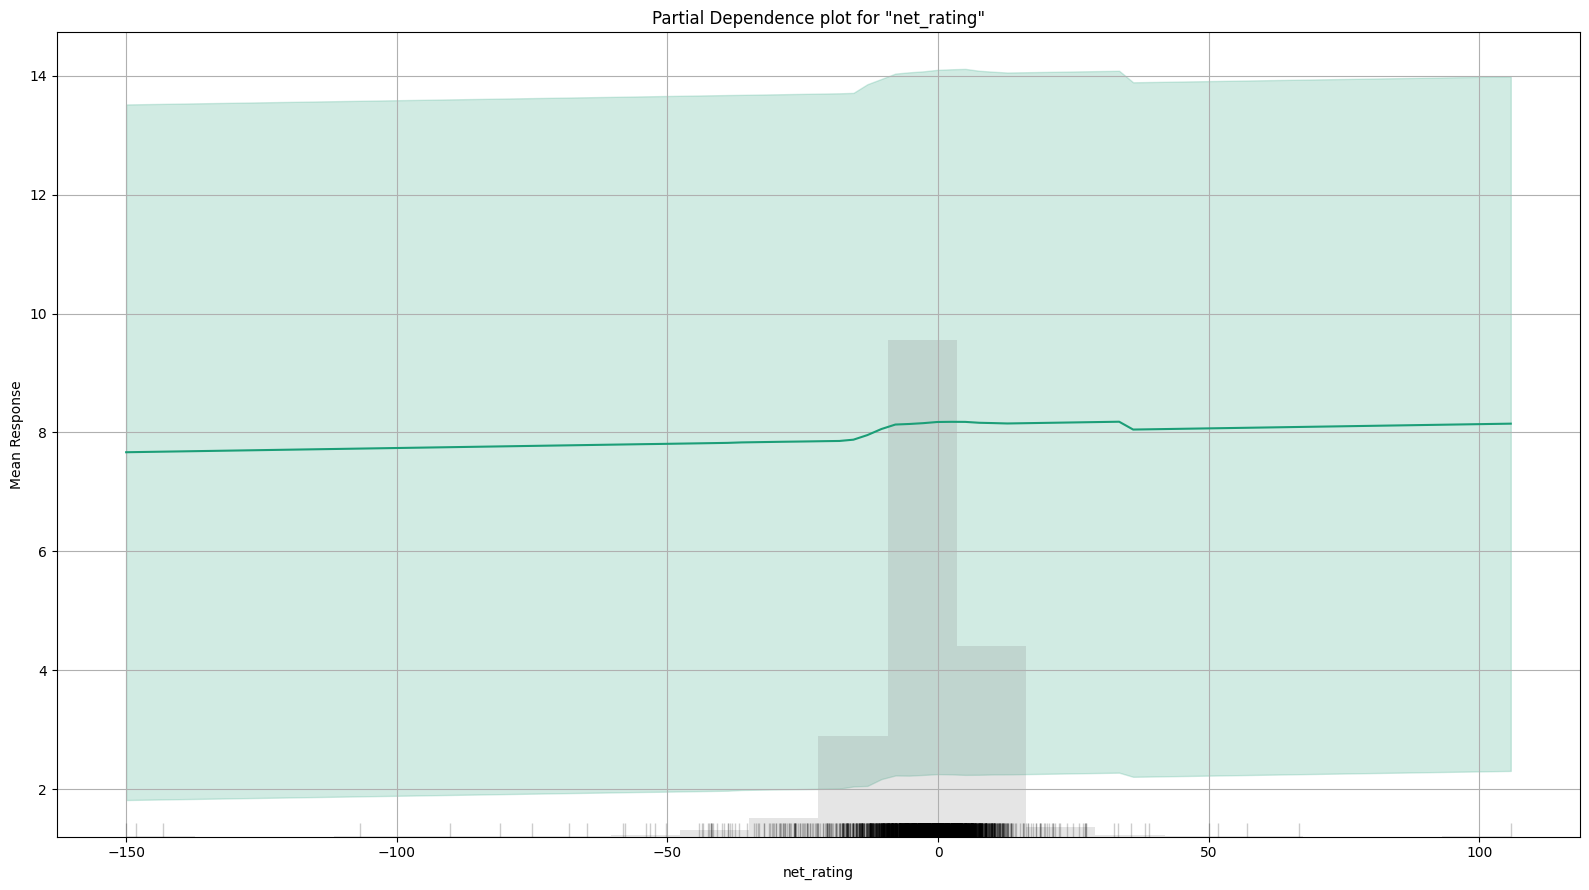

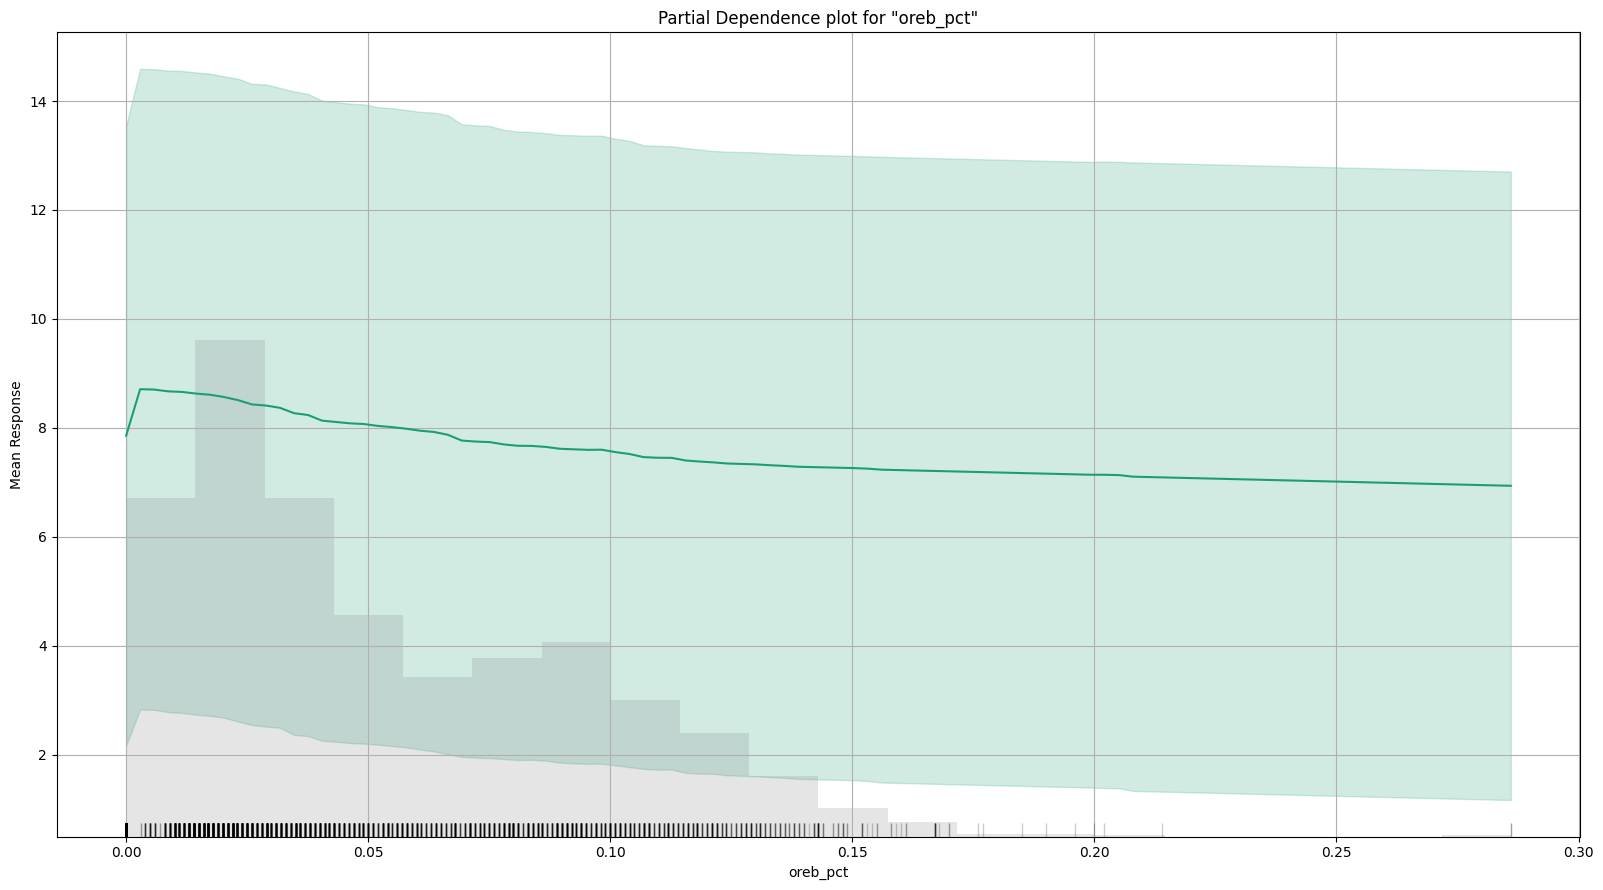

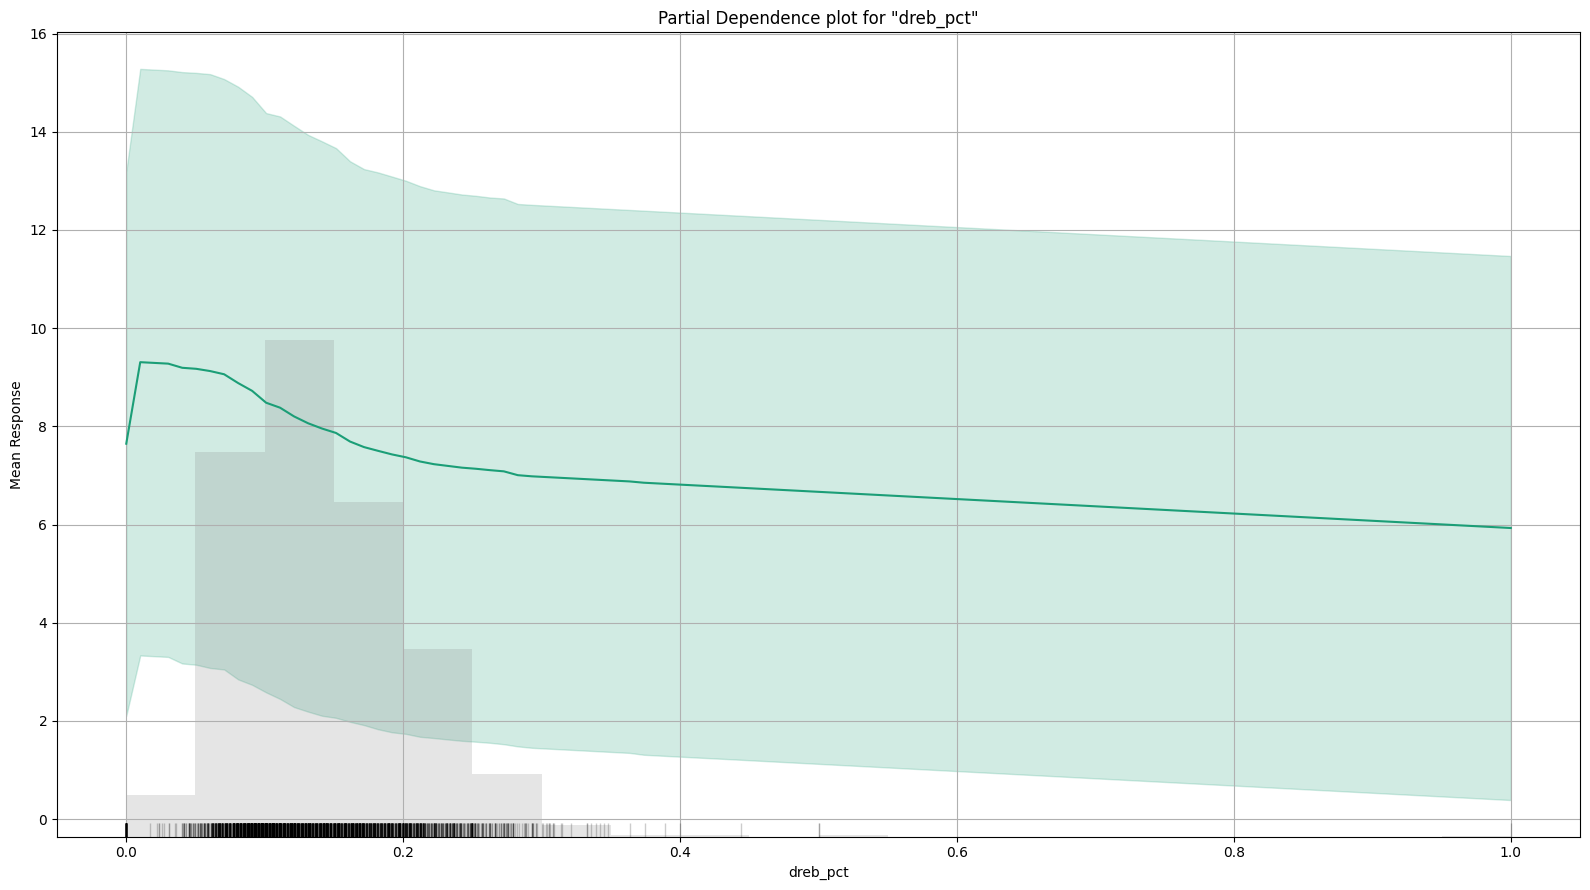

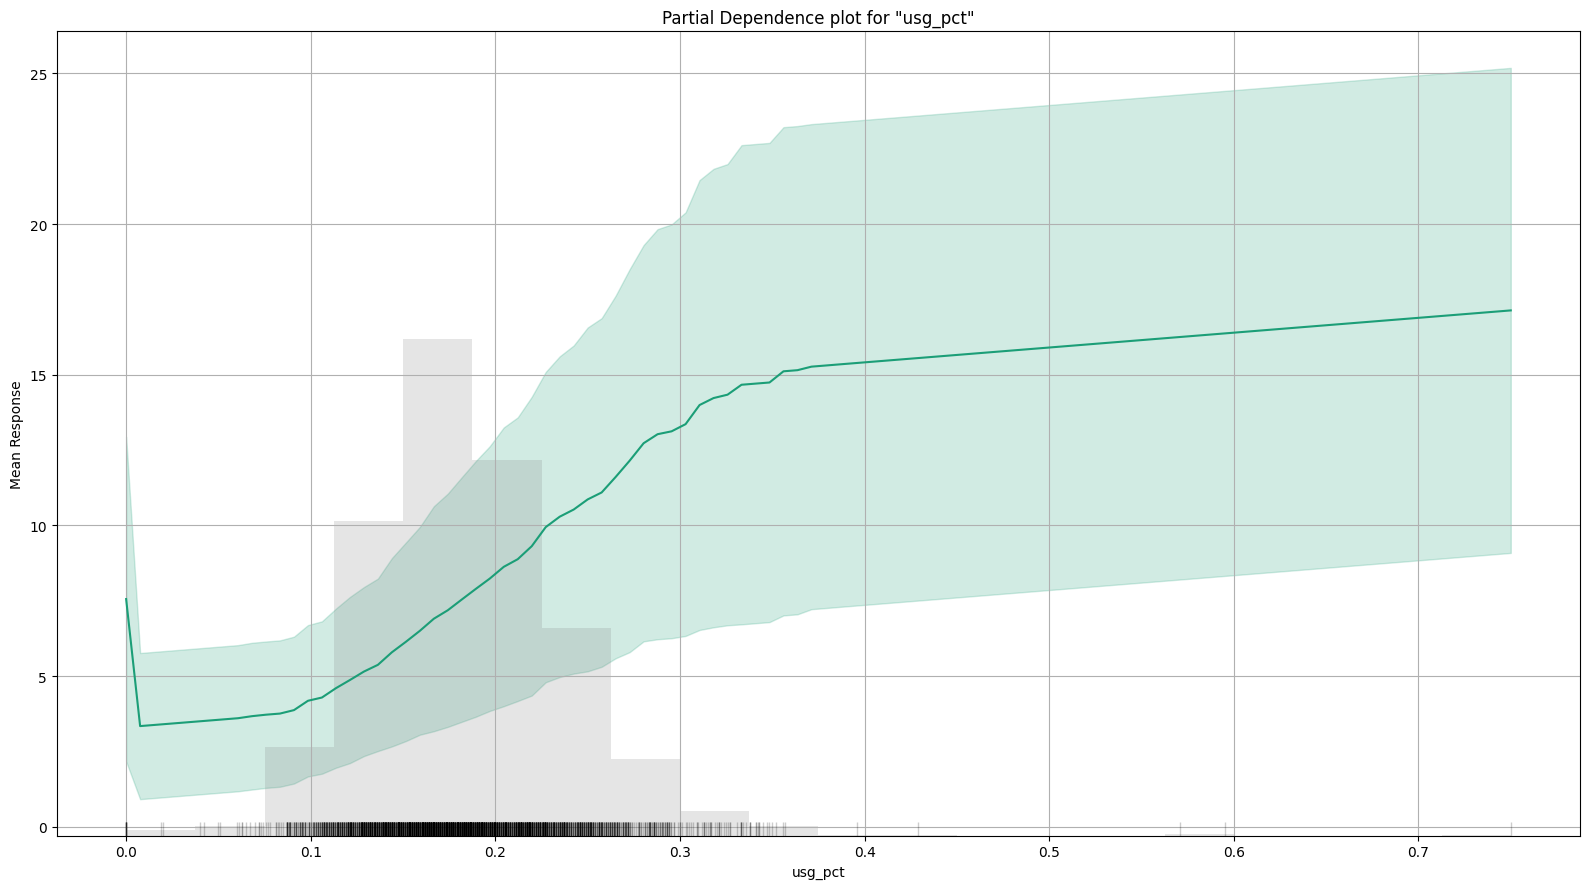

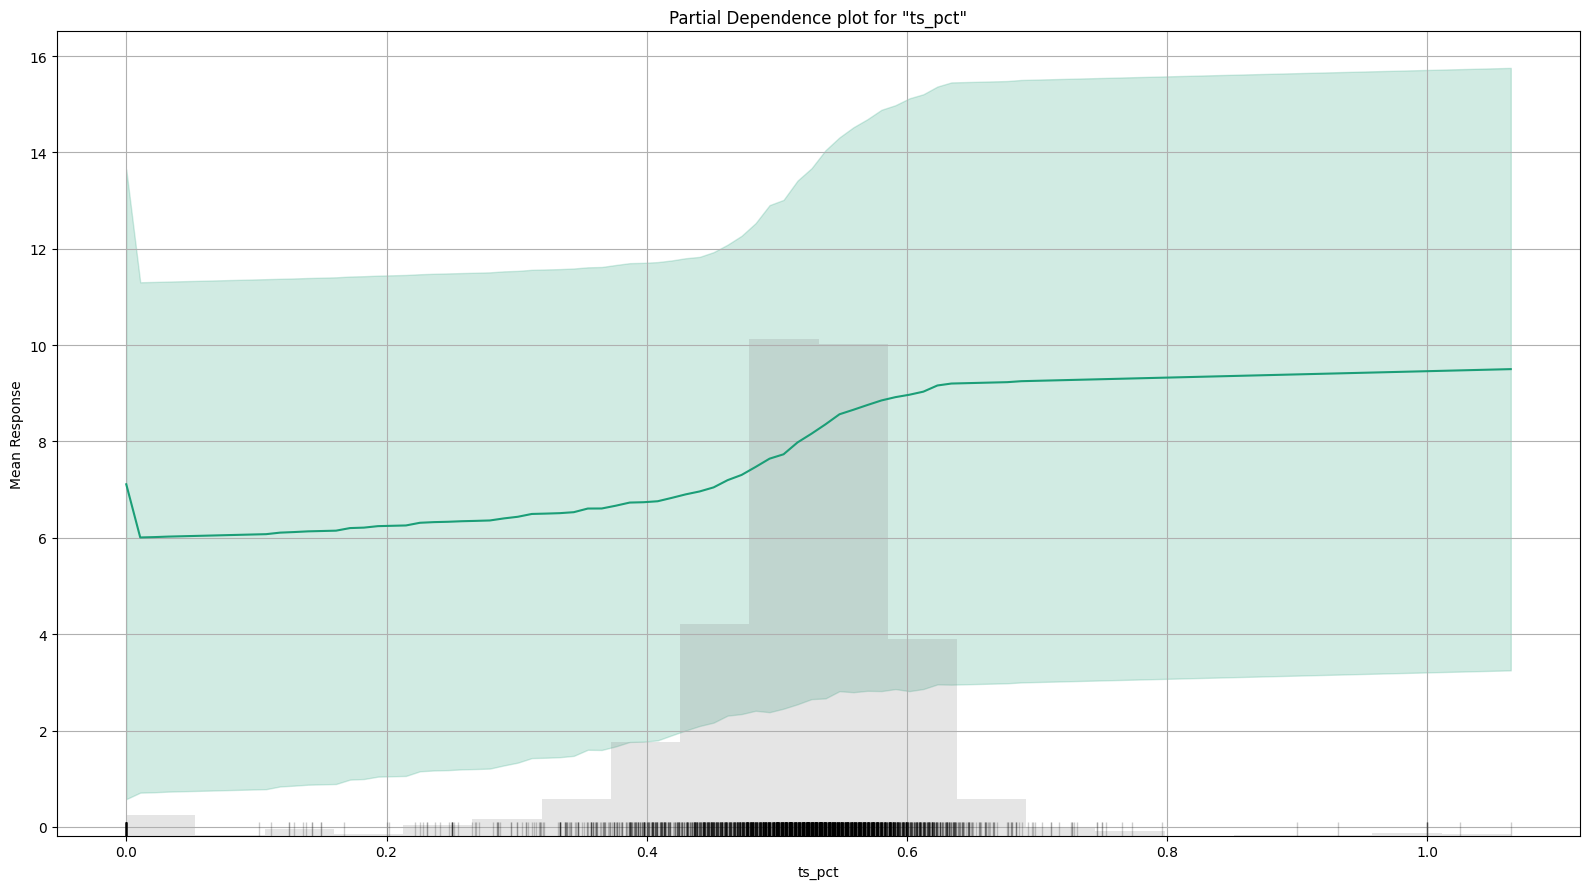

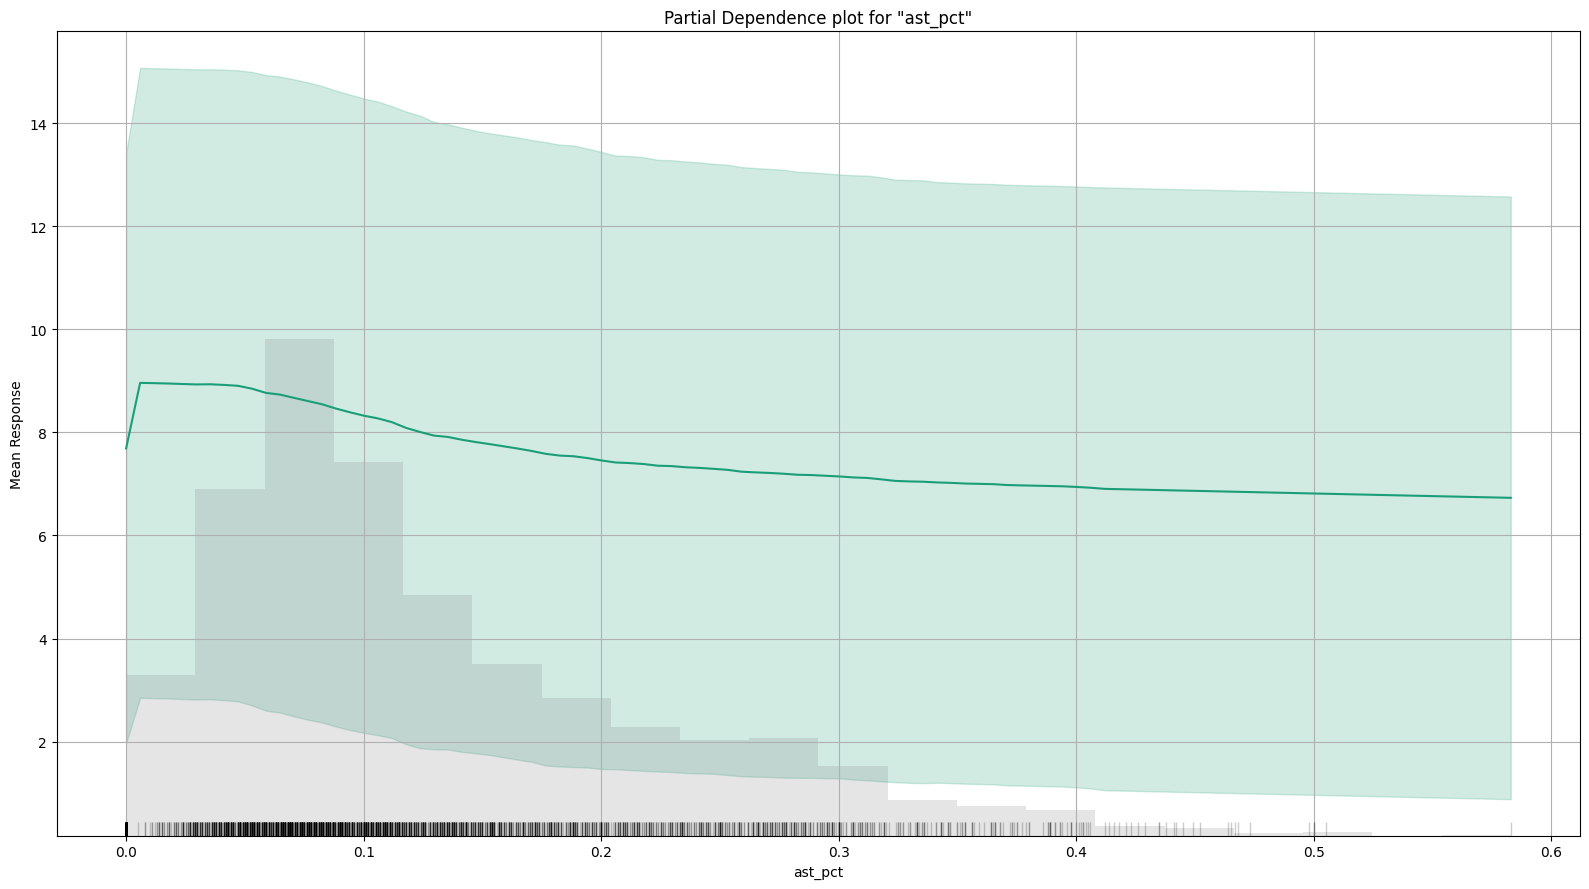

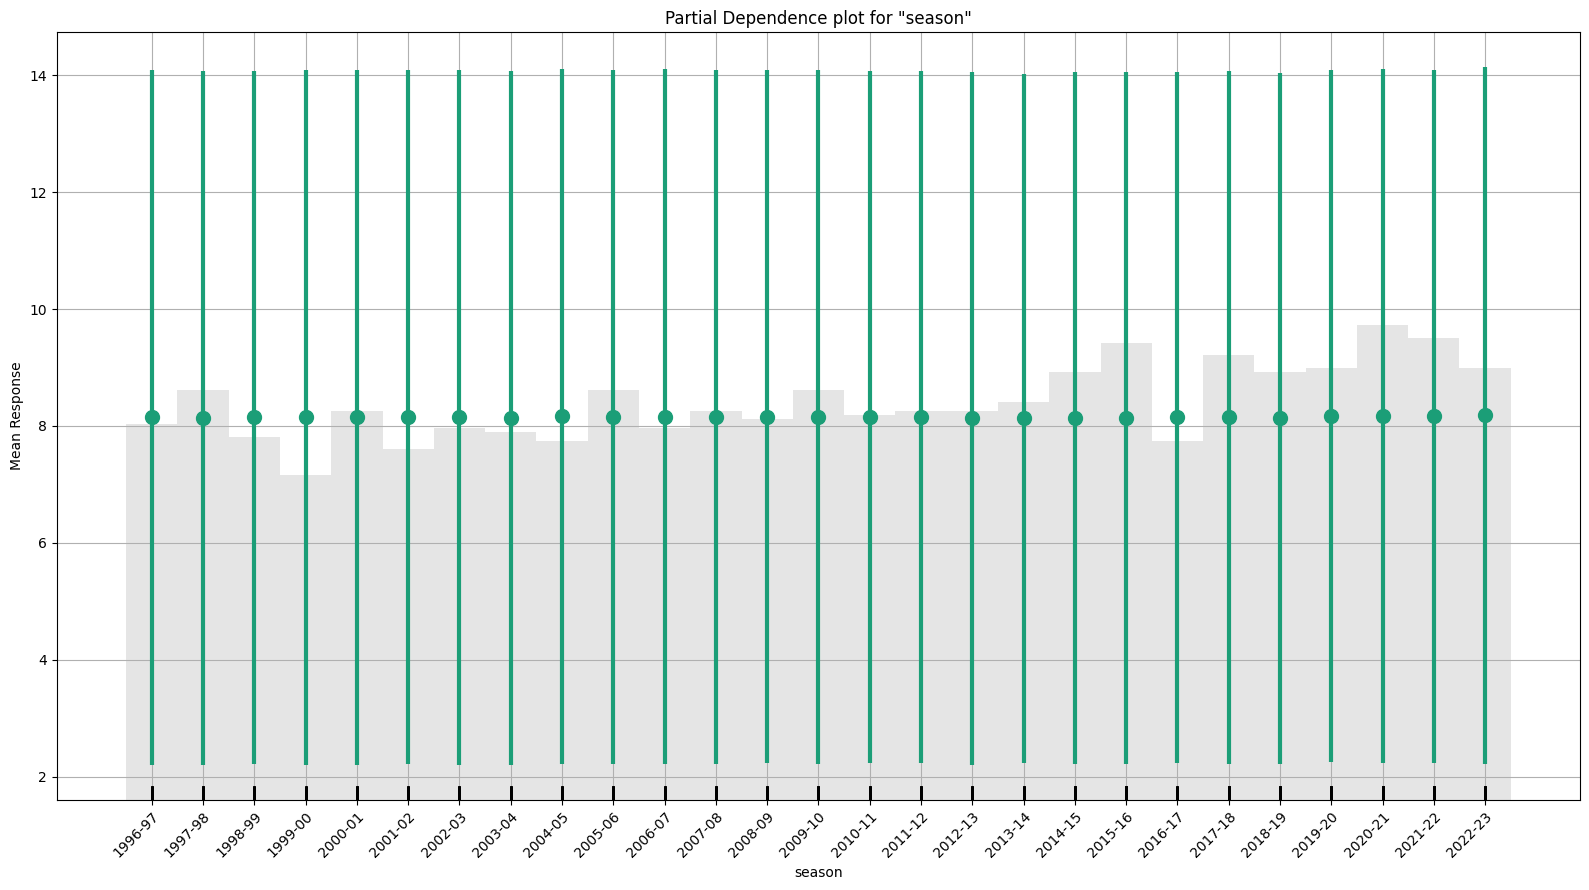

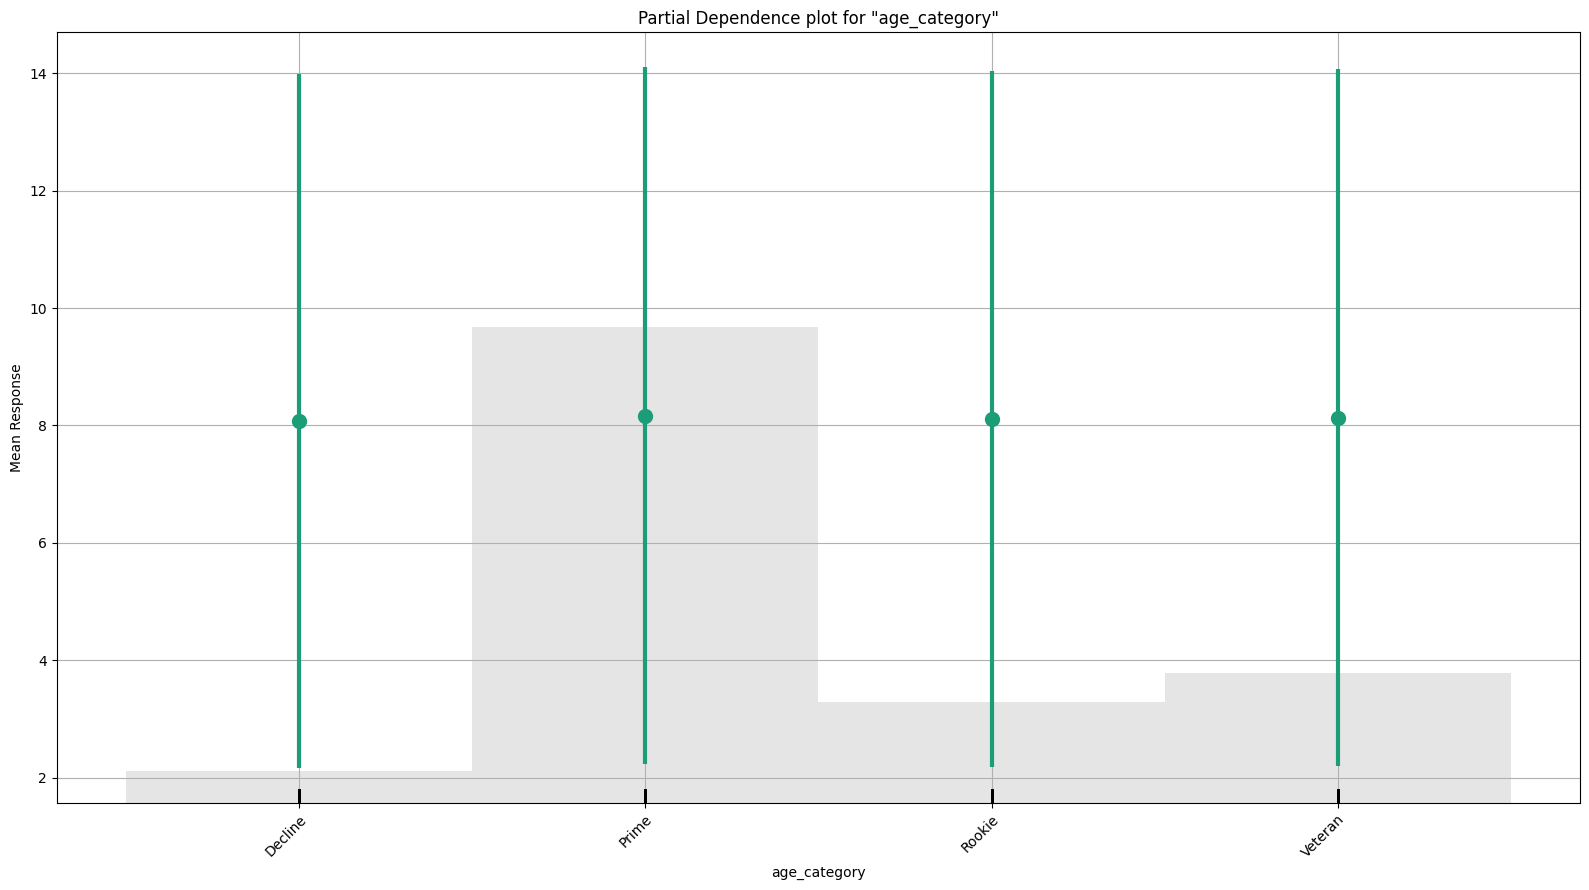

In [73]:
# Explain a single H2O model (e.g. leader model from AutoML)
exm = best_model.explain(test, include_explanations=["pdp"])

Partial Dependence Plots (PDPs) visualize the effect of a single feature on the predicted outcome of a model, averaged over the distribution of the other features. By analyzing a PDP, we can discern how changes in the predictor are associated with changes in the average predicted response.

For example, we can infer that more rebounds are likely to be associated with a higher predicted performance score, according to the model. The increase appears to be somewhat steady, without sudden jumps or declines, indicating a relatively linear relationship as per the model's predictions.

###SHAP Analysis of All 3 Models

####Linear Model

PermutationExplainer explainer: 10276it [06:09, 27.40it/s]                           


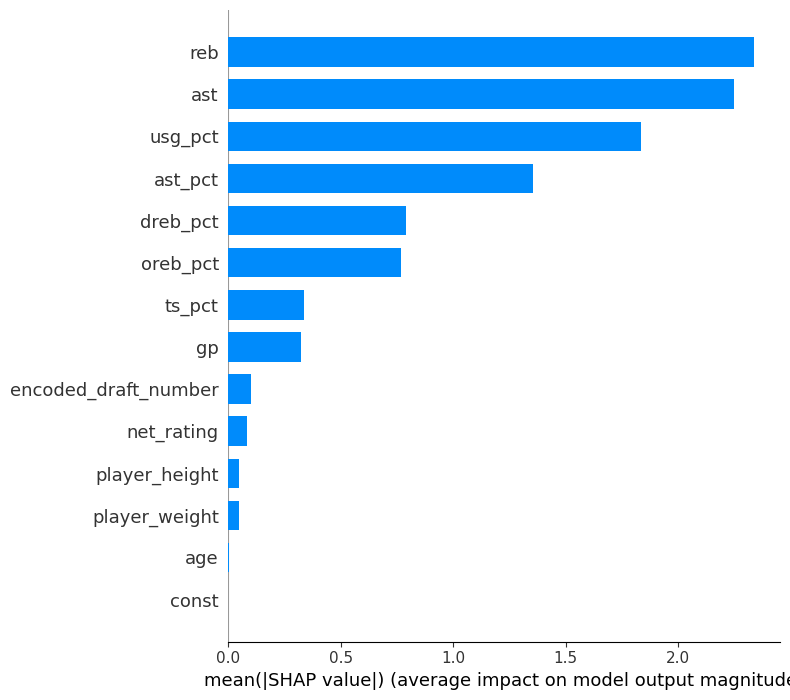

In [82]:
# Explain the model with SHAP
explainer = shap.Explainer(linear_model.predict, X_train_sm)
shap_values = explainer(X_train_sm)

# Visualize the SHAP values
shap.summary_plot(shap_values, X_train_sm, plot_type="bar")

####Tree-Based Model

In [ ]:
# Create a SHAP explainer object
explainer = shap.Explainer(rf, rf_X_train)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(rf_X_test)

# Summary plot
shap.summary_plot(shap_values, rf_X_test, feature_names=rf_X_test.columns)

 60%|============        | 1550/2569 [02:21<01:32]       

####AutoML Best Model

In [100]:
lb = aml.leaderboard

# Convert the leaderboard to a pandas DataFrame
lb_df = lb.as_data_frame()

# Find the model_id of the GLM model
glm_model_id = lb_df[lb_df['model_id'].str.contains("GLM")].iloc[0]['model_id']

# Get the GLM model
glm_model = h2o.get_model(glm_model_id)

/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


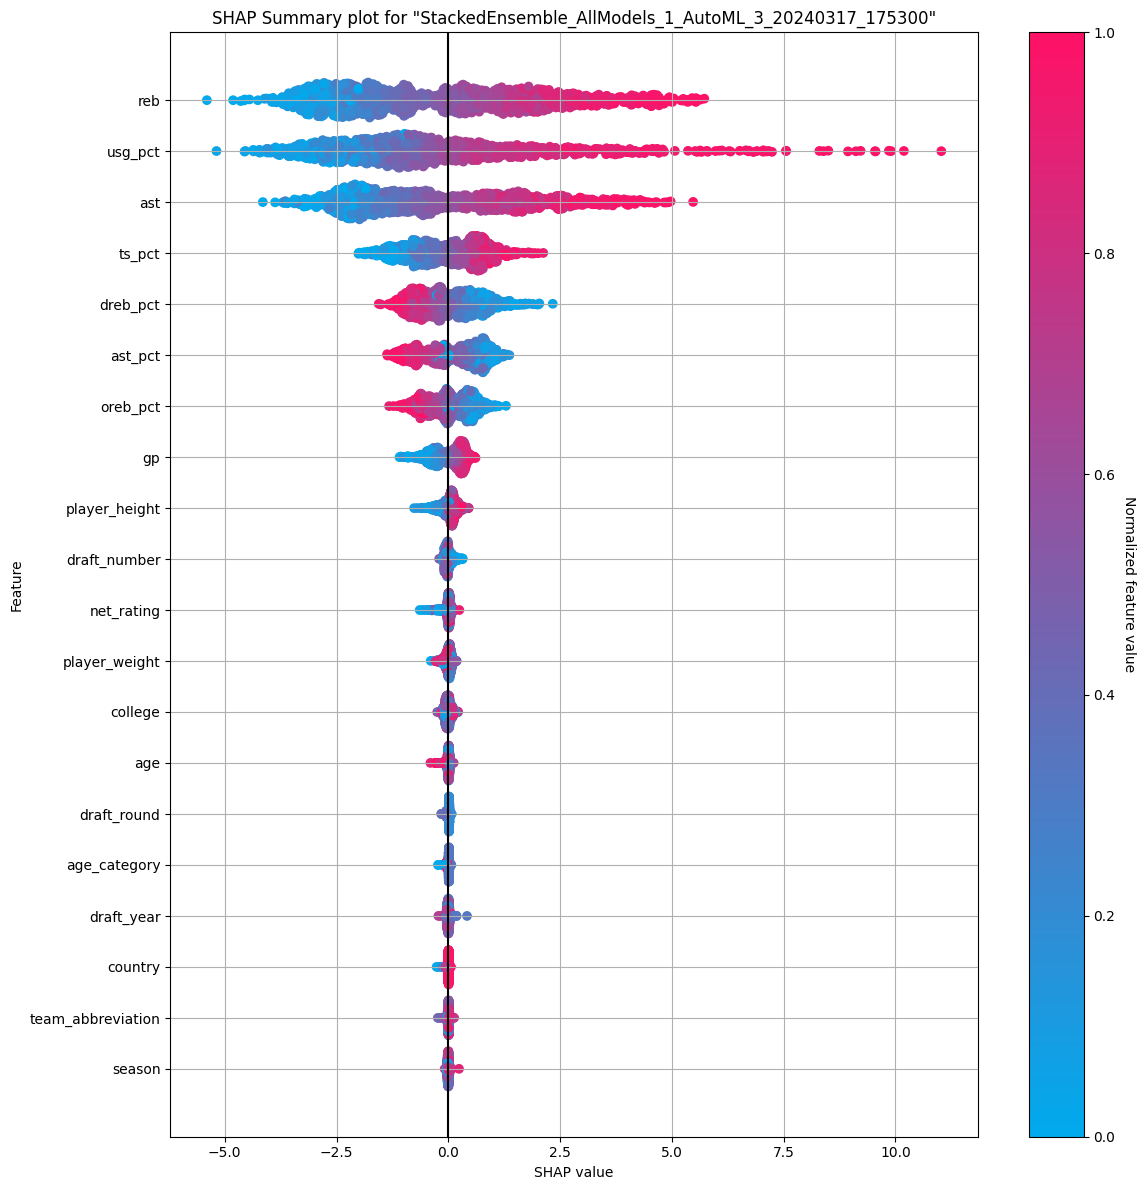

In [121]:
# Assuming 'train' is your H2OFrame containing the training data
# This will split your data into a 1% sample and the rest, you can adjust the ratios as needed
splits = train.split_frame(ratios=[0.01], seed=42)

# Use the smaller split as the background dataset for SHAP calculations
background = splits[0]

shapr_plot = best_model.shap_summary_plot(test, background_frame=background)

- Each point on the plot represents a SHAP value for a feature and an individual observation.
- The position on the x-axis shows the impact of that value on the model's prediction, with points to the right indicating a higher prediction and points to the left indicating a lower prediction.
- The color indicates the feature value for the observation, with cool colors (like blue) typically representing lower values and warm colors (like red) representing higher values.
- Features are ordered by the sum of SHAP value magnitudes over all samples, showing the most influential features at the top.
- For example, high 'reb' (likely rebounds) contributes to a higher prediction, while lower 'reb' contributes to a lower prediction. The density of the points suggests the distribution of the SHAP values—where you see more overlap, that feature value has more consistent influence across the observations.

From the procedure followed to interpret the models of each type, SHAP analysis offers a consistent and comprehensive view of feature influence across models. It quantifies the impact of each feature on individual predictions, facilitating a deeper understanding of model behavior in both global (across the entire dataset) and local (per-instance) contexts, unlike traditional methods that provide a single average measure. (For example, coeffecients and feature importance values)